<a href="https://colab.research.google.com/github/Pauldeeny02/thesis-dhc-model/blob/main/sensitivity_analysis_PD_DH_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y glpk-utils
import os
import pyomo.environ as pyo
from pyomo.environ import *

def build_and_solve_model(share_2025=0.50, share_2040=0.75, share_2050=1.00):
    # Create model
    model = ConcreteModel()

    # Define sets
    technologies = ['air_source_hp', 'gas_boiler', 'industrial_hp', 'biomass_boiler','sofc', 'geothermal_hp', 'electric_boiler']
    years = range(2025, 2051)  # From 2025 to 2050

    # Define parameters
    M = 10**9  # A sufficiently large constant (upper bound for x)
    peak_heat_demand = 5.9458593  # MW
    EFLH = 1800  # Effective Full Load Hours
    r = 0.04  # Discount rate

    # Energy Prices
    average_gas_price = 66.10 # (eur/MWh)
    average_electricity_price_business = 228.1 # (eur/MWh)
    average_biomass_price = 55 # (eur/MWh)
    average_biogas_price = 120 # (eur/MWh)

    # Efficiencies
    air_source_hp_efficiency = 3.60
    geothermal_hp_efficiency = 1.60
    industrial_hp_efficiency =  4.35# estimated value of every heat pump
    biomass_boiler_efficiency = 1.00
    sofc_heat_efficiency = 0.55
    gas_boiler_efficiency = .90
    electric_boiler_efficiency = 1

    # Discount rate
    discount_rate = 0.04

    # Define year mapping (0 → 2025, 25 → 2050)
    year_offset = 2025
    years_to_check = range(2025, 2051)

    # Dictionary of input data
    data_dicts = {
    "nominal_investment": {
        ('air_source_hp', 0): 1.01, ('air_source_hp', 5): 0.91, ('air_source_hp', 15): 0.91, ('air_source_hp', 25): 0.91,
        ('gas_boiler', 0): 0.06, ('gas_boiler', 5): 0.05, ('gas_boiler', 25): 0.05,
        ('industrial_hp', 0): 1.32, ('industrial_hp', 5): 1.21, ('industrial_hp', 15): 1.21, ('industrial_hp', 25): 1.21,
        ('biomass_boiler', 0): 0.7337, ('biomass_boiler', 5): 0.7018, ('biomass_boiler', 25): 0.6274,
        ('sofc', 0): 2.13, ('sofc', 5): 2.13, ('sofc', 25): 0.85,
        ('geothermal_hp', 0): 1.31, ('geothermal_hp', 5): 1.27, ('geothermal_hp', 15): 1.22, ('geothermal_hp', 25): 1.19,
        ('electric_boiler', 0): .15, ('electric_boiler', 5): .15, ('electric_boiler', 15): .14, ('electric_boiler', 25): .14,
    },
    "variable_om": {
        ('air_source_hp', 0): 2.33, ('air_source_hp', 5): 2.67, ('air_source_hp', 15): 2.33, ('air_source_hp', 25): 2.84,
        ('gas_boiler', 0): 1.17, ('gas_boiler', 5): 1.06, ('gas_boiler', 25): 1.06,
        ('industrial_hp', 0): 2.86, ('industrial_hp', 5): 2.86, ('industrial_hp', 15): 3.39, ('industrial_hp', 25): 3.37,
        ('biomass_boiler', 0): 3.6474, ('biomass_boiler', 5): 3.6474, ('biomass_boiler', 25): 4.0195,
        ('sofc', 0): 0.00, ('sofc', 5): 0.00, ('sofc', 25): 0.00,
        ('geothermal_hp', 0): 2.24, ('geothermal_hp', 5): 2.28, ('geothermal_hp', 15): 2.26, ('geothermal_hp', 25): 2.24,
        ('electric_boiler', 0): .96, ('electric_boiler', 5): 1.06, ('electric_boiler', 15): 1.06, ('electric_boiler', 25): 1.06,
    },
    "fixed_om": {
        ('air_source_hp', 0): 2126.75, ('air_source_hp', 5): 2126.75, ('air_source_hp', 15): 2126.75, ('air_source_hp', 25): 2126.75,
        ('gas_boiler', 0): 2020.41, ('gas_boiler', 5): 2020.41, ('gas_boiler', 25): 1807.73,
        ('industrial_hp', 0): 2126.75, ('industrial_hp', 5): 2126.75, ('industrial_hp', 14): 2126.75, ('industrial_hp', 25): 2126.75,
        ('biomass_boiler', 0): 33496.24, ('biomass_boiler', 5): 33496.24, ('biomass_boiler', 25): 31475.83,
        ('sofc', 0): 106337.27, ('sofc', 5): 106337.27, ('sofc', 25): 42534.91,
        ('geothermal_hp', 0): 11484.43, ('geothermal_hp', 5): 11165.41, ('geothermal_hp', 15): 10740.06, ('geothermal_hp', 25): 10421.05,
        ('electric_boiler', 0): 1137.81, ('electric_boiler', 5): 1084.64, ('electric_boiler', 15): 1084.64, ('electric_boiler', 25): 978.3,
    }
}

    # Function to map years and fill missing values
    def process_data(data):
        mapped_data = {(tech, year + year_offset): value for (tech, year), value in data.items()}
        filled_data = {}

        for tech in {tech for tech, _ in mapped_data.keys()}:  # Unique technologies
            last_value = None
            for year in years_to_check:
                if (tech, year) in mapped_data:
                    last_value = mapped_data[(tech, year)]  # Update last known value
                filled_data[(tech, year)] = last_value  # Assign last known value

        return filled_data

    # Process all datasets
    processed_data = {key: process_data(value) for key, value in data_dicts.items()}
        # Decision Variables
    model.x = Var(technologies, years, within=NonNegativeReals, bounds=(0, M))
    model.y = Var(technologies, years, within=Binary)
    model.xy = Var(technologies, years, within=NonNegativeReals)
    model.z = Var(technologies, years, within=NonNegativeReals)

    # Constraints to linearize xy = x * y
    def linearization_rule1(model, tech, t):
        return model.xy[tech, t] <= M * model.y[tech, t]
    def linearization_rule2(model, tech, t):
        return model.xy[tech, t] <= model.x[tech, t]
    def linearization_rule4(model, tech, t):
        return model.xy[tech, t] >= 0

    model.linearization1 = Constraint(technologies, years, rule=linearization_rule1)
    model.linearization2 = Constraint(technologies, years, rule=linearization_rule2)
    model.linearization4 = Constraint(technologies, years, rule=linearization_rule4)

    # Heat demand constraint
    def heat_demand_constraint(model, t):
        return sum(model.xy[tech, t] for tech in technologies) == peak_heat_demand
    model.heat_demand = Constraint(years, rule=heat_demand_constraint)

    # Define technology categories
    renewable_techs = ['air_source_hp', 'biomass_boiler', 'geothermal_hp']
    waste_heat_techs = ['industrial_hp']

    # Renewable constraint with custom shares
    def renewable_constraint(model, t):
        if t >= 2025 and t < 2040:
            return sum(model.xy[tech, t] for tech in (renewable_techs + waste_heat_techs)) >= share_2025 * sum(model.xy[tech, t] for tech in technologies)
        elif t >= 2040 and t < 2050:
            return sum(model.xy[tech, t] for tech in (renewable_techs + waste_heat_techs)) >= share_2040 * sum(model.xy[tech, t] for tech in technologies)
        elif t >= 2050:
            return sum(model.xy[tech, t] for tech in (renewable_techs + waste_heat_techs)) >= share_2050 * sum(model.xy[tech, t] for tech in technologies)
        else:
            return Constraint.Skip
    model.renewable_constraint = Constraint(years, rule=renewable_constraint)

    # Add z constraint
    model.z_constraint = ConstraintList()
    for tech in technologies:
        for t in years:
            if t == 2025:
                model.z_constraint.add(model.z[tech, t] == model.x[tech, t])
            else:
                model.z_constraint.add(model.z[tech, t] == model.x[tech, t] - model.x[tech, t-1])

    # Tech capacity constraints (you can add more if needed)
    model.industrial_hp_capacity = Constraint(years, rule=lambda model, t: model.x['industrial_hp', t] <= 1)
    model.biomass_boiler_capacity = Constraint(years, rule=lambda model, t: model.x['biomass_boiler', t] <= 3)
    model.electric_boiler_limit = Constraint(years, rule=lambda model, t: model.xy['electric_boiler', t] <= 2)

    def total_cost_2(model):
        return sum((
        # Capital cost
        processed_data["nominal_investment"][(tech, t)] * model.z[tech, t] * 1e6 +

        # Fixed O&M cost
        processed_data["fixed_om"][(tech, t)] * model.xy[tech, t] +

        # Variable O&M cost (per MWh output)
        processed_data["variable_om"][(tech, t)] * model.xy[tech, t] * EFLH +

        # Energy costs
        (
            model.xy[tech, t] * EFLH / gas_boiler_efficiency * average_gas_price
            if tech == 'gas_boiler' else
            model.xy[tech, t] * EFLH / air_source_hp_efficiency * average_electricity_price_business
            if tech == 'air_source_hp' else
            model.xy[tech, t] * EFLH / industrial_hp_efficiency * average_electricity_price_business
            if tech == 'industrial_hp' else
            model.xy[tech, t] * EFLH / geothermal_hp_efficiency * average_electricity_price_business
            if tech == 'geothermal_hp' else
            model.xy[tech, t] * EFLH / electric_boiler_efficiency * average_electricity_price_business
            if tech == 'electric_boiler' else
            model.xy[tech, t] * EFLH / biomass_boiler_efficiency * average_biomass_price
            if tech == 'biomass_boiler' else
            model.xy[tech, t] * EFLH / sofc_heat_efficiency * average_biogas_price
            if tech == 'sofc' else 0
        )
    ) * (1 / (1 + discount_rate)**(t - 2025))
    for tech in technologies for t in years)

    # Objective
    model.total_cost_2 = Objective(rule=total_cost_2, sense=minimize)

    # Solve model
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
    result = solver.solve(model, tee=False)

    # Calculate results
    total_cost_value = pyo.value(model.total_cost_2)
    heat_demand = sum(
        (pyo.value(model.xy[tech, t]) * EFLH) * (1 / (1.04 ** (t - 2025)))
        for tech in technologies for t in years
    )
    LCOH_i = total_cost_value / heat_demand

    return {
        "LCOH": LCOH_i,
        "total_cost": total_cost_value,
        "share_2025": share_2025,
        "share_2040": share_2040,
        "share_2050": share_2050,
        "model": model,
        "status": str(result.solver.termination_condition)
    }


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 34 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

In [ ]:
scenarios = [
    (0.40, 0.60, 0.90),
    (0.50, 0.75, 1.00),  # baseline
    (0.60, 0.85, 1.00),
    (0.70, 0.90, 1.00),
    (0.50, 0.50, 0.50)   # flat, low-renewable case
]

In [ ]:
results = []

for s25, s40, s50 in scenarios:
    print(f"Running scenario: 2025={s25*100:.0f}%, 2040={s40*100:.0f}%, 2050={s50*100:.0f}%")
    res = build_and_solve_model(share_2025=s25, share_2040=s40, share_2050=s50)
    results.append(res)


Running scenario: 2025=40%, 2040=60%, 2050=90%
Running scenario: 2025=50%, 2040=75%, 2050=100%
Running scenario: 2025=60%, 2040=85%, 2050=100%
Running scenario: 2025=70%, 2040=90%, 2050=100%
Running scenario: 2025=50%, 2040=50%, 2050=50%


In [ ]:
import pandas as pd

df = pd.DataFrame(results)
df = df[["share_2025", "share_2040", "share_2050", "LCOH", "total_cost", "status"]]
print(df.round(2))


   share_2025  share_2040  share_2050   LCOH   total_cost   status
0         0.4        0.60         0.9  91.97  16361819.56  optimal
1         0.5        0.75         1.0  94.57  16823136.69  optimal
2         0.6        0.85         1.0  96.09  17094151.21  optimal
3         0.7        0.90         1.0  97.33  17315198.28  optimal
4         0.5        0.50         0.5  89.22  15871623.60  optimal


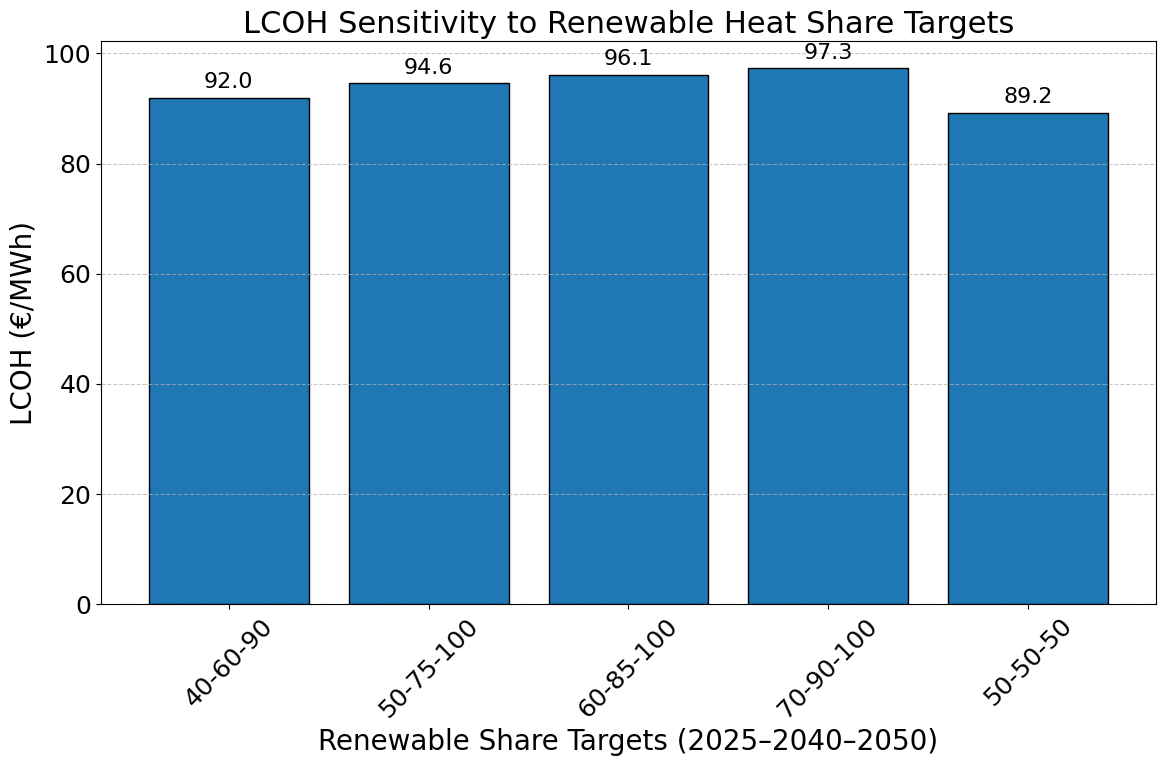

In [ ]:
import matplotlib.pyplot as plt

# Update font sizes globally
plt.rcParams.update({
    "font.size": 18,           # Base font size
    "axes.titlesize": 22,      # Title font
    "axes.labelsize": 20,      # x and y labels
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
})

labels = [f"{int(r['share_2025']*100)}-{int(r['share_2040']*100)}-{int(r['share_2050']*100)}" for r in results]
lcoh_values = [r['LCOH'] for r in results]

plt.figure(figsize=(12, 8))  # Slightly larger figure too
bars = plt.bar(labels, lcoh_values, edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f"{height:.1f}",
             ha='center', va='bottom', fontsize=16)

plt.xlabel("Renewable Share Targets (2025–2040–2050)")
plt.ylabel("LCOH (€/MWh)")
plt.title("LCOH Sensitivity to Renewable Heat Share Targets")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


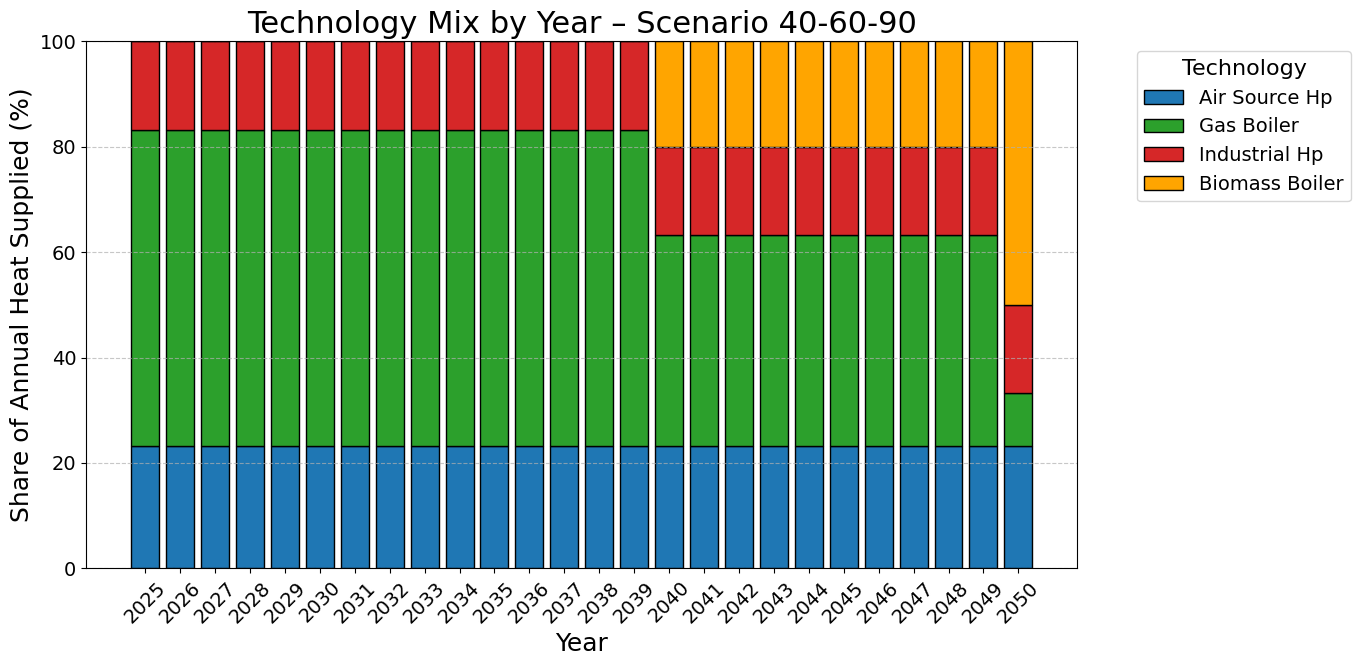

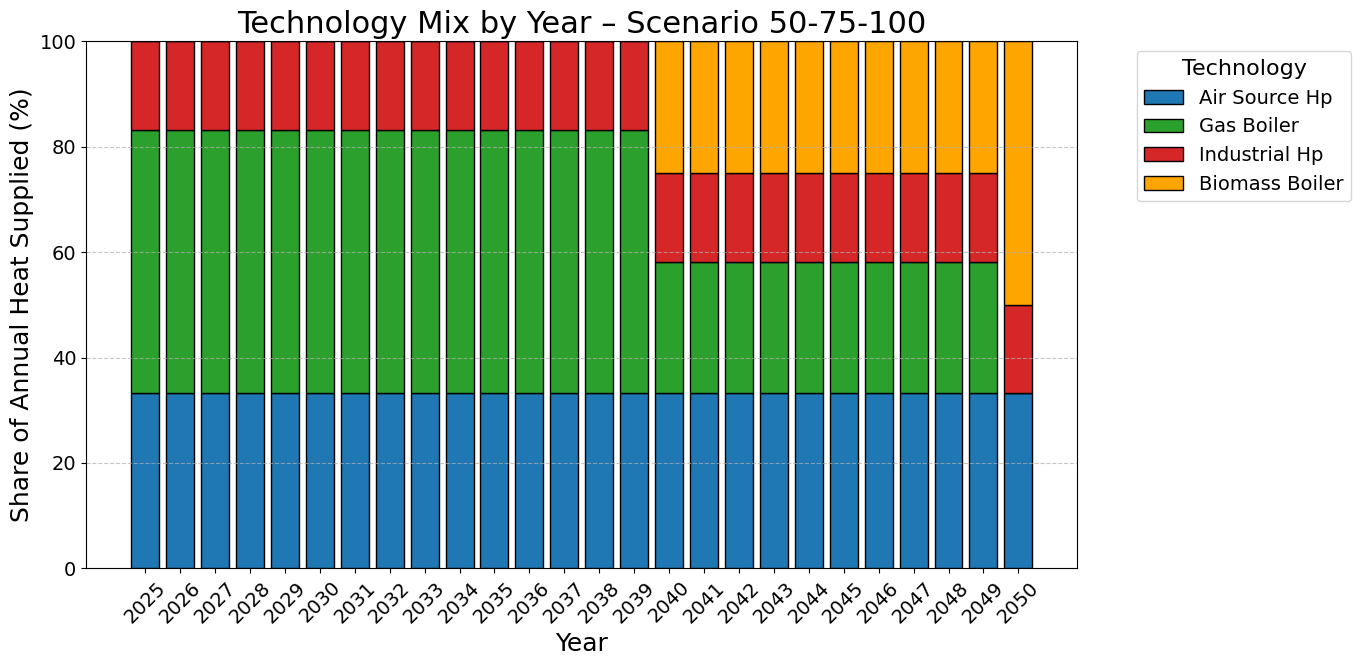

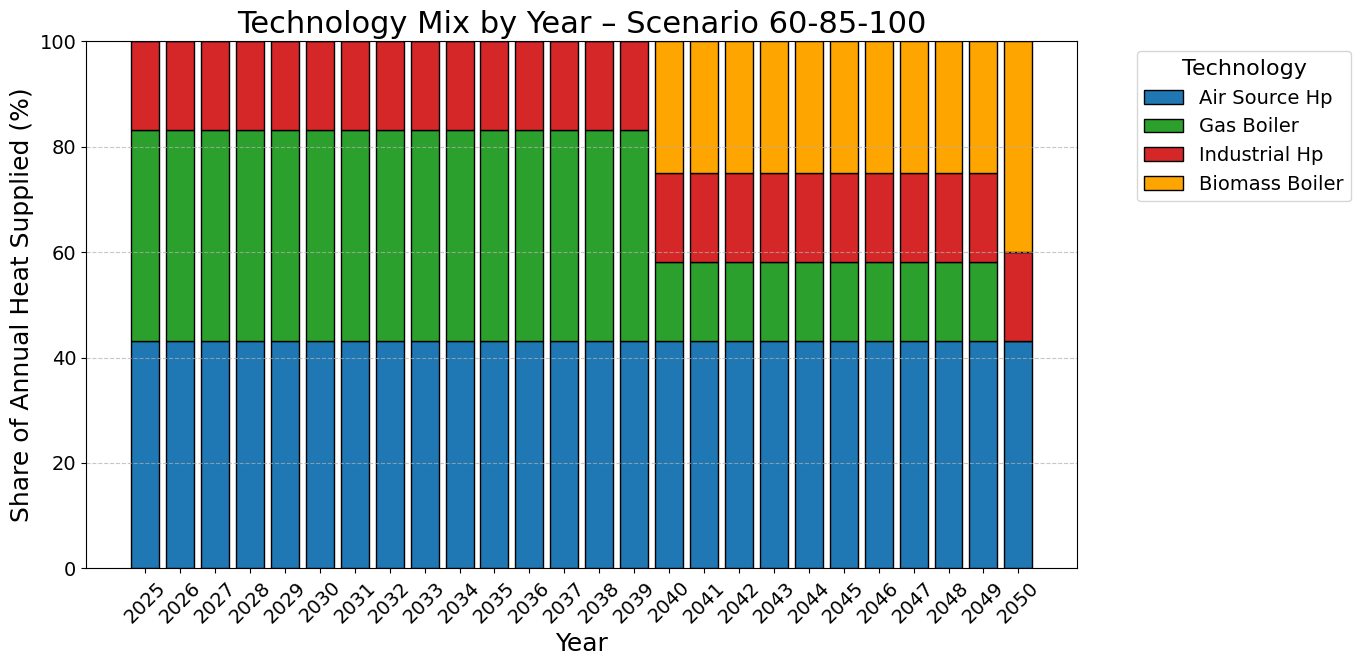

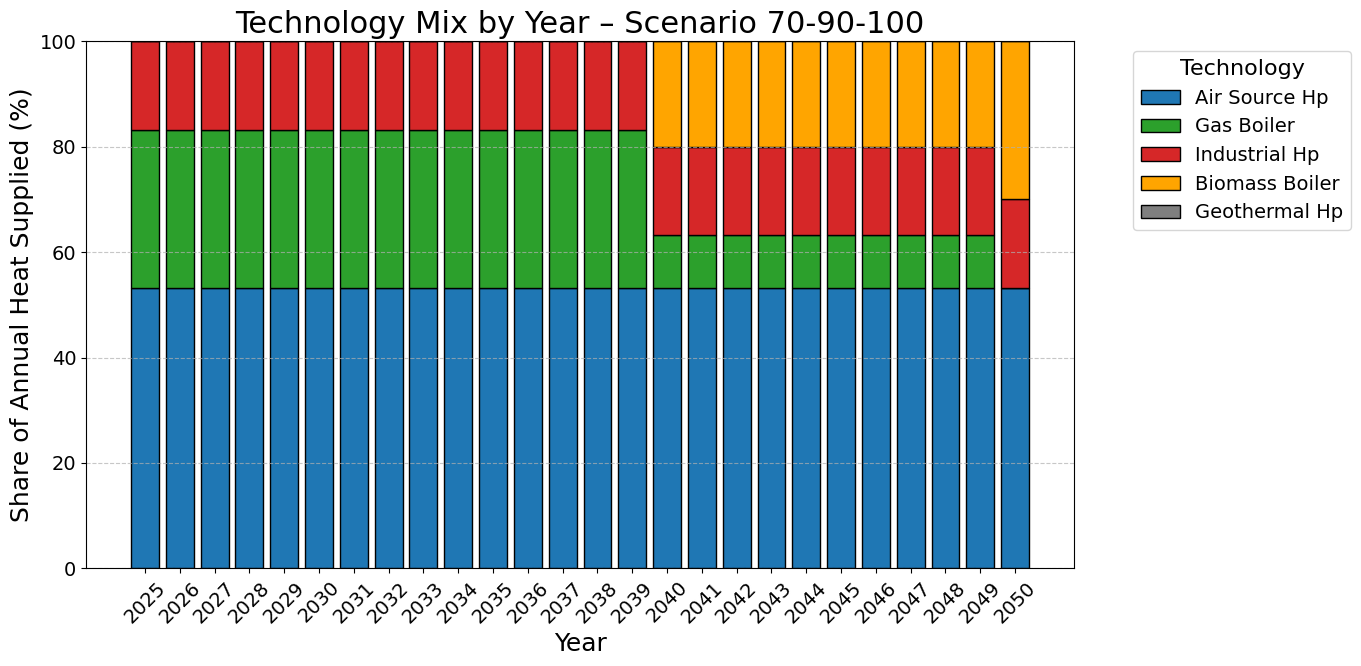

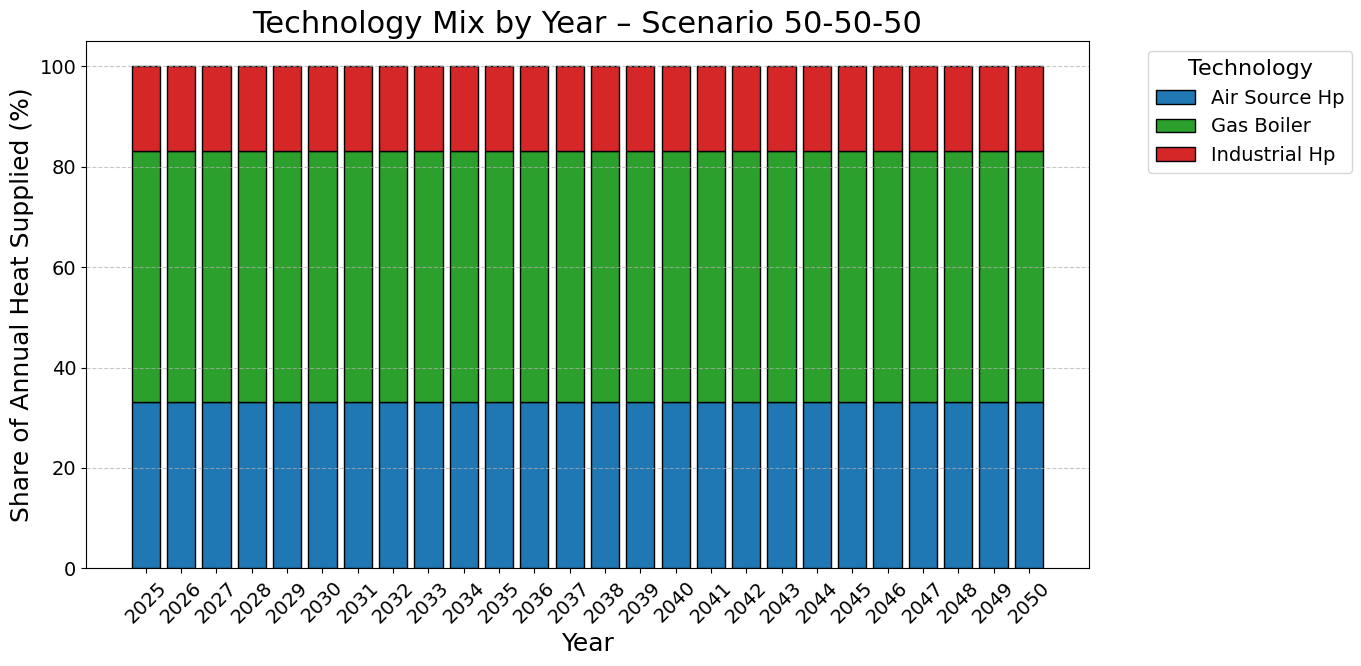


--- Scenario: Renewable Share 40-60-90 ---
2025: air_source_hp → 1.38 MW
2025: gas_boiler → 3.57 MW
2025: industrial_hp → 1.00 MW
2026: air_source_hp → 1.38 MW
2026: gas_boiler → 3.57 MW
2026: industrial_hp → 1.00 MW
2027: air_source_hp → 1.38 MW
2027: gas_boiler → 3.57 MW
2027: industrial_hp → 1.00 MW
2028: air_source_hp → 1.38 MW
2028: gas_boiler → 3.57 MW
2028: industrial_hp → 1.00 MW
2029: air_source_hp → 1.38 MW
2029: gas_boiler → 3.57 MW
2029: industrial_hp → 1.00 MW
2030: air_source_hp → 1.38 MW
2030: gas_boiler → 3.57 MW
2030: industrial_hp → 1.00 MW
2031: air_source_hp → 1.38 MW
2031: gas_boiler → 3.57 MW
2031: industrial_hp → 1.00 MW
2032: air_source_hp → 1.38 MW
2032: gas_boiler → 3.57 MW
2032: industrial_hp → 1.00 MW
2033: air_source_hp → 1.38 MW
2033: gas_boiler → 3.57 MW
2033: industrial_hp → 1.00 MW
2034: air_source_hp → 1.38 MW
2034: gas_boiler → 3.57 MW
2034: industrial_hp → 1.00 MW
2035: air_source_hp → 1.38 MW
2035: gas_boiler → 3.57 MW
2035: industrial_hp → 1.00 MW

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Constants
EFLH = 1800
years = range(2025, 2051)
techs = ['air_source_hp', 'gas_boiler', 'industrial_hp', 'biomass_boiler', 'sofc', 'geothermal_hp', 'electric_boiler']
labels = [f"{int(r['share_2025']*100)}-{int(r['share_2040']*100)}-{int(r['share_2050']*100)}" for r in results]

# Define custom colors
tech_colors = {
    'air_source_hp': 'tab:blue',
    'gas_boiler': 'tab:green',
    'industrial_hp': 'tab:red',
    'biomass_boiler': 'orange',
    'sofc': 'tab:purple',
    'geothermal_hp': 'tab:gray',
    'electric_boiler': 'tab:brown'
}

# Loop over each scenario
for i, res in enumerate(results):
    model = res["model"]
    scenario_label = labels[i]

    # Collect heat output per tech per year
    data = {
        "Year": [],
        "Technology": [],
        "Heat_MWh": []
    }

    for year in years:
        for tech in techs:
            heat = pyo.value(model.xy[tech, year]) * EFLH
            data["Year"].append(year)
            data["Technology"].append(tech)
            data["Heat_MWh"].append(heat)

    df = pd.DataFrame(data)

    # Pivot and calculate percent
    df_pivot = df.pivot(index="Year", columns="Technology", values="Heat_MWh")
    df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

    # Drop unused technologies
    used_techs = [tech for tech in techs if tech in df_percent.columns and (df_percent[tech] != 0).any()]

    # Plot
    plt.figure(figsize=(14, 7))
    bottom = np.zeros(len(df_percent))

    for tech in used_techs:
        plt.bar(df_percent.index, df_percent[tech], bottom=bottom,
                label=tech.replace("_", " ").title(),
                color=tech_colors[tech],
                edgecolor='black')
        bottom += df_percent[tech].fillna(0)

    plt.title(f"Technology Mix by Year – Scenario {scenario_label}", fontsize=22)
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("Share of Annual Heat Supplied (%)", fontsize=18)
    plt.xticks(df_percent.index, rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
# Constants
years = range(2025, 2051)
techs = ['air_source_hp', 'gas_boiler', 'industrial_hp', 'biomass_boiler', 'sofc', 'geothermal_hp', 'electric_boiler']

# Labels for renewable share scenarios
labels = [f"{int(r['share_2025']*100)}-{int(r['share_2040']*100)}-{int(r['share_2050']*100)}" for r in results]

# Print capacity values for each scenario
for i, res in enumerate(results):
    model = res["model"]
    label = labels[i]
    print(f"\n--- Scenario: Renewable Share {label} ---")

    for year in years:
        for tech in techs:
            capacity = pyo.value(model.xy[tech, year])
            if capacity > 0:
                print(f"{year}: {tech} → {capacity:.2f} MW")


## Fuel Prices ##

In [ ]:
def build_and_solve_model(
    share_2025=0.50,
    share_2040=0.75,
    share_2050=1.00,
    gas_price=66.10,
    electricity_price=228.1,
    biomass_price=55.0,
    biogas_price=120.0
):

    # Create model
    model = ConcreteModel()

    # Define sets
    technologies = ['air_source_hp', 'gas_boiler', 'industrial_hp', 'biomass_boiler','sofc', 'geothermal_hp', 'electric_boiler']
    years = range(2025, 2051)  # From 2025 to 2050

    # Define parameters
    M = 10**9  # A sufficiently large constant (upper bound for x)
    peak_heat_demand = 5.9458593  # MW
    EFLH = 1800  # Effective Full Load Hours
    r = 0.04  # Discount rate

    average_gas_price = gas_price
    average_electricity_price_business = electricity_price
    average_biomass_price = biomass_price
    average_biogas_price = biogas_price


    # Efficiencies
    air_source_hp_efficiency = 3.60
    geothermal_hp_efficiency = 1.60
    industrial_hp_efficiency =  4.35# estimated value of every heat pump
    biomass_boiler_efficiency = 1.00
    sofc_heat_efficiency = 0.55
    gas_boiler_efficiency = .90
    electric_boiler_efficiency = 1

    # Discount rate
    discount_rate = 0.04

    # Define year mapping (0 → 2025, 25 → 2050)
    year_offset = 2025
    years_to_check = range(2025, 2051)

    # Dictionary of input data
    data_dicts = {
    "nominal_investment": {
        ('air_source_hp', 0): 1.01, ('air_source_hp', 5): 0.91, ('air_source_hp', 15): 0.91, ('air_source_hp', 25): 0.91,
        ('gas_boiler', 0): 0.06, ('gas_boiler', 5): 0.05, ('gas_boiler', 25): 0.05,
        ('industrial_hp', 0): 1.32, ('industrial_hp', 5): 1.21, ('industrial_hp', 15): 1.21, ('industrial_hp', 25): 1.21,
        ('biomass_boiler', 0): 0.7337, ('biomass_boiler', 5): 0.7018, ('biomass_boiler', 25): 0.6274,
        ('sofc', 0): 2.13, ('sofc', 5): 2.13, ('sofc', 25): 0.85,
        ('geothermal_hp', 0): 1.31, ('geothermal_hp', 5): 1.27, ('geothermal_hp', 15): 1.22, ('geothermal_hp', 25): 1.19,
        ('electric_boiler', 0): .15, ('electric_boiler', 5): .15, ('electric_boiler', 15): .14, ('electric_boiler', 25): .14,
    },
    "variable_om": {
        ('air_source_hp', 0): 2.33, ('air_source_hp', 5): 2.67, ('air_source_hp', 15): 2.33, ('air_source_hp', 25): 2.84,
        ('gas_boiler', 0): 1.17, ('gas_boiler', 5): 1.06, ('gas_boiler', 25): 1.06,
        ('industrial_hp', 0): 2.86, ('industrial_hp', 5): 2.86, ('industrial_hp', 15): 3.39, ('industrial_hp', 25): 3.37,
        ('biomass_boiler', 0): 3.6474, ('biomass_boiler', 5): 3.6474, ('biomass_boiler', 25): 4.0195,
        ('sofc', 0): 0.00, ('sofc', 5): 0.00, ('sofc', 25): 0.00,
        ('geothermal_hp', 0): 2.24, ('geothermal_hp', 5): 2.28, ('geothermal_hp', 15): 2.26, ('geothermal_hp', 25): 2.24,
        ('electric_boiler', 0): .96, ('electric_boiler', 5): 1.06, ('electric_boiler', 15): 1.06, ('electric_boiler', 25): 1.06,
    },
    "fixed_om": {
        ('air_source_hp', 0): 2126.75, ('air_source_hp', 5): 2126.75, ('air_source_hp', 15): 2126.75, ('air_source_hp', 25): 2126.75,
        ('gas_boiler', 0): 2020.41, ('gas_boiler', 5): 2020.41, ('gas_boiler', 25): 1807.73,
        ('industrial_hp', 0): 2126.75, ('industrial_hp', 5): 2126.75, ('industrial_hp', 14): 2126.75, ('industrial_hp', 25): 2126.75,
        ('biomass_boiler', 0): 33496.24, ('biomass_boiler', 5): 33496.24, ('biomass_boiler', 25): 31475.83,
        ('sofc', 0): 106337.27, ('sofc', 5): 106337.27, ('sofc', 25): 42534.91,
        ('geothermal_hp', 0): 11484.43, ('geothermal_hp', 5): 11165.41, ('geothermal_hp', 15): 10740.06, ('geothermal_hp', 25): 10421.05,
        ('electric_boiler', 0): 1137.81, ('electric_boiler', 5): 1084.64, ('electric_boiler', 15): 1084.64, ('electric_boiler', 25): 978.3,
    }
}

    # Function to map years and fill missing values
    def process_data(data):
        mapped_data = {(tech, year + year_offset): value for (tech, year), value in data.items()}
        filled_data = {}

        for tech in {tech for tech, _ in mapped_data.keys()}:  # Unique technologies
            last_value = None
            for year in years_to_check:
                if (tech, year) in mapped_data:
                    last_value = mapped_data[(tech, year)]  # Update last known value
                filled_data[(tech, year)] = last_value  # Assign last known value

        return filled_data

    # Process all datasets
    processed_data = {key: process_data(value) for key, value in data_dicts.items()}
        # Decision Variables
    model.x = Var(technologies, years, within=NonNegativeReals, bounds=(0, M))
    model.y = Var(technologies, years, within=Binary)
    model.xy = Var(technologies, years, within=NonNegativeReals)
    model.z = Var(technologies, years, within=NonNegativeReals)

    # Constraints to linearize xy = x * y
    def linearization_rule1(model, tech, t):
        return model.xy[tech, t] <= M * model.y[tech, t]
    def linearization_rule2(model, tech, t):
        return model.xy[tech, t] <= model.x[tech, t]
    def linearization_rule4(model, tech, t):
        return model.xy[tech, t] >= 0

    model.linearization1 = Constraint(technologies, years, rule=linearization_rule1)
    model.linearization2 = Constraint(technologies, years, rule=linearization_rule2)
    model.linearization4 = Constraint(technologies, years, rule=linearization_rule4)

    # Heat demand constraint
    def heat_demand_constraint(model, t):
        return sum(model.xy[tech, t] for tech in technologies) == peak_heat_demand
    model.heat_demand = Constraint(years, rule=heat_demand_constraint)

    # Define technology categories
    renewable_techs = ['air_source_hp', 'biomass_boiler', 'geothermal_hp']
    waste_heat_techs = ['industrial_hp']

    # Renewable constraint with custom shares
    def renewable_constraint(model, t):
        if t >= 2025 and t < 2040:
            return sum(model.xy[tech, t] for tech in (renewable_techs + waste_heat_techs)) >= share_2025 * sum(model.xy[tech, t] for tech in technologies)
        elif t >= 2040 and t < 2050:
            return sum(model.xy[tech, t] for tech in (renewable_techs + waste_heat_techs)) >= share_2040 * sum(model.xy[tech, t] for tech in technologies)
        elif t >= 2050:
            return sum(model.xy[tech, t] for tech in (renewable_techs + waste_heat_techs)) >= share_2050 * sum(model.xy[tech, t] for tech in technologies)
        else:
            return Constraint.Skip
    model.renewable_constraint = Constraint(years, rule=renewable_constraint)

    # Add z constraint
    model.z_constraint = ConstraintList()
    for tech in technologies:
        for t in years:
            if t == 2025:
                model.z_constraint.add(model.z[tech, t] == model.x[tech, t])
            else:
                model.z_constraint.add(model.z[tech, t] == model.x[tech, t] - model.x[tech, t-1])

    # Tech capacity constraints (you can add more if needed)
    model.industrial_hp_capacity = Constraint(years, rule=lambda model, t: model.x['industrial_hp', t] <= 1)
    model.biomass_boiler_capacity = Constraint(years, rule=lambda model, t: model.x['biomass_boiler', t] <= 3)
    model.electric_boiler_limit = Constraint(years, rule=lambda model, t: model.xy['electric_boiler', t] <= 2)

    def total_cost_2(model):
        return sum((
        # Capital cost
        processed_data["nominal_investment"][(tech, t)] * model.z[tech, t] * 1e6 +

        # Fixed O&M cost
        processed_data["fixed_om"][(tech, t)] * model.xy[tech, t] +

        # Variable O&M cost (per MWh output)
        processed_data["variable_om"][(tech, t)] * model.xy[tech, t] * EFLH +

        # Energy costs
        (
            model.xy[tech, t] * EFLH / gas_boiler_efficiency * average_gas_price
            if tech == 'gas_boiler' else
            model.xy[tech, t] * EFLH / air_source_hp_efficiency * average_electricity_price_business
            if tech == 'air_source_hp' else
            model.xy[tech, t] * EFLH / industrial_hp_efficiency * average_electricity_price_business
            if tech == 'industrial_hp' else
            model.xy[tech, t] * EFLH / geothermal_hp_efficiency * average_electricity_price_business
            if tech == 'geothermal_hp' else
            model.xy[tech, t] * EFLH / electric_boiler_efficiency * average_electricity_price_business
            if tech == 'electric_boiler' else
            model.xy[tech, t] * EFLH / biomass_boiler_efficiency * average_biomass_price
            if tech == 'biomass_boiler' else
            model.xy[tech, t] * EFLH / sofc_heat_efficiency * average_biogas_price
            if tech == 'sofc' else 0
        )
    ) * (1 / (1 + discount_rate)**(t - 2025))
    for tech in technologies for t in years)

    # Objective
    model.total_cost_2 = Objective(rule=total_cost_2, sense=minimize)

    # Solve model
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
    result = solver.solve(model, tee=False)

    # Calculate results
    total_cost_value = pyo.value(model.total_cost_2)
    heat_demand = sum(
        (pyo.value(model.xy[tech, t]) * EFLH) * (1 / (1.04 ** (t - 2025)))
        for tech in technologies for t in years
    )
    LCOH_i = total_cost_value / heat_demand

    return {
        "LCOH": LCOH_i,
        "total_cost": total_cost_value,
        "share_2025": share_2025,
        "share_2040": share_2040,
        "share_2050": share_2050,
        "model": model,
        "status": str(result.solver.termination_condition)
    }


In [ ]:
energy_price_scenarios = {
    "Electricity Price": [
        (114.0, 66.1, 55.0, 120.0),
        (171.1, 66.1, 55.0, 120.0),
        (228.1, 66.1, 55.0, 120.0),
        (285.1, 66.1, 55.0, 120.0),
        (342.1, 66.1, 55.0, 120.0),
    ],
    "Gas Price": [
        (228.1, 33.1, 55.0, 120.0),
        (228.1, 49.6, 55.0, 120.0),
        (228.1, 66.1, 55.0, 120.0),
        (228.1, 82.6, 55.0, 120.0),
        (228.1, 99.2, 55.0, 120.0),
    ],
    "Biomass Price": [
        (228.1, 66.1, 27.5, 120.0),
        (228.1, 66.1, 41.2, 120.0),
        (228.1, 66.1, 55.0, 120.0),
        (228.1, 66.1, 68.8, 120.0),
        (228.1, 66.1, 82.5, 120.0),
    ],
    "Biogas Price": [
        (228.1, 66.1, 55.0, 60.0),
        (228.1, 66.1, 55.0, 90.0),
        (228.1, 66.1, 55.0, 120.0),
        (228.1, 66.1, 55.0, 150.0),
        (228.1, 66.1, 55.0, 180.0),
    ],
}


In [ ]:
sensitivity_results = []

for param, scenario_list in energy_price_scenarios.items():
    for i, (elec_p, gas_p, bio_p, biogas_p) in enumerate(scenario_list):
        res = build_and_solve_model(
            electricity_price=elec_p,
            gas_price=gas_p,
            biomass_price=bio_p,
            biogas_price=biogas_p
        )
        res.update({
            "Varied Parameter": param,
            "Electricity Price": elec_p,
            "Gas Price": gas_p,
            "Biomass Price": bio_p,
            "Biogas Price": biogas_p,
            "Level (%)": [50, 75, 100, 125, 150][i]
        })
        sensitivity_results.append(res)


In [ ]:
import pandas as pd

df_energy_sens = pd.DataFrame(sensitivity_results)
df_energy_sens["total_cost"] = df_energy_sens["total_cost"] / 1e6  # convert to M€


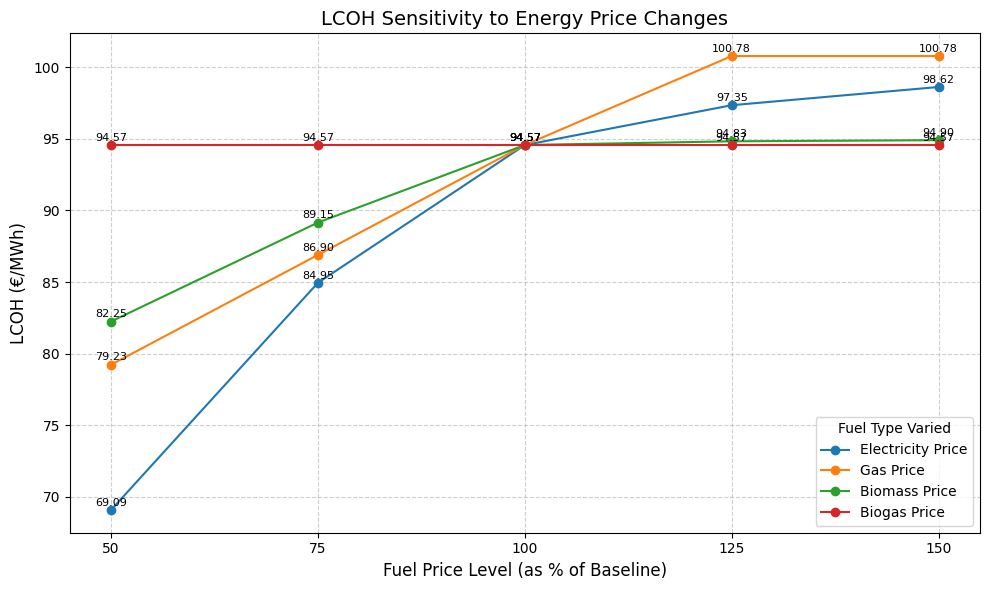

          LCOH  total_cost  share_2025  share_2040  share_2050   model  \
0    69.088494   12.290746         0.5        0.75         1.0  [None]   
1    84.949606   15.112415         0.5        0.75         1.0  [None]   
2    94.565881   16.823137         0.5        0.75         1.0  [None]   
3    97.345699   17.317662         0.5        0.75         1.0  [None]   
4    98.617813   17.543970         0.5        0.75         1.0  [None]   
5    79.229305   14.094782         0.5        0.75         1.0  [None]   
6    86.897593   15.458959         0.5        0.75         1.0  [None]   
7    94.565881   16.823137         0.5        0.75         1.0  [None]   
8   100.778608   17.928372         0.5        0.75         1.0  [None]   
9   100.778608   17.928372         0.5        0.75         1.0  [None]   
10   82.246621   14.631558         0.5        0.75         1.0  [None]   
11   89.154462   15.860453         0.5        0.75         1.0  [None]   
12   94.565881   16.823137         0.5

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

colors = {
    "Electricity Price": "tab:blue",
    "Gas Price": "tab:orange",
    "Biomass Price": "tab:green",
    "Biogas Price": "tab:red"
}

for param in df_energy_sens["Varied Parameter"].unique():
    subset = df_energy_sens[df_energy_sens["Varied Parameter"] == param]
    x = subset["Level (%)"]
    y = subset["LCOH"]

    plt.plot(x, y, marker='o', label=param, color=colors[param])
    for i in range(len(x)):
        plt.text(x.iloc[i], y.iloc[i] + 0.3, f"{y.iloc[i]:.2f}", ha='center', fontsize=8)

plt.xlabel("Fuel Price Level (as % of Baseline)", fontsize=12)
plt.ylabel("LCOH (€/MWh)", fontsize=12)
plt.title("LCOH Sensitivity to Energy Price Changes", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([50, 75, 100, 125, 150])
plt.legend(title="Fuel Type Varied")
plt.tight_layout()
plt.show()
print(df_energy_sens)

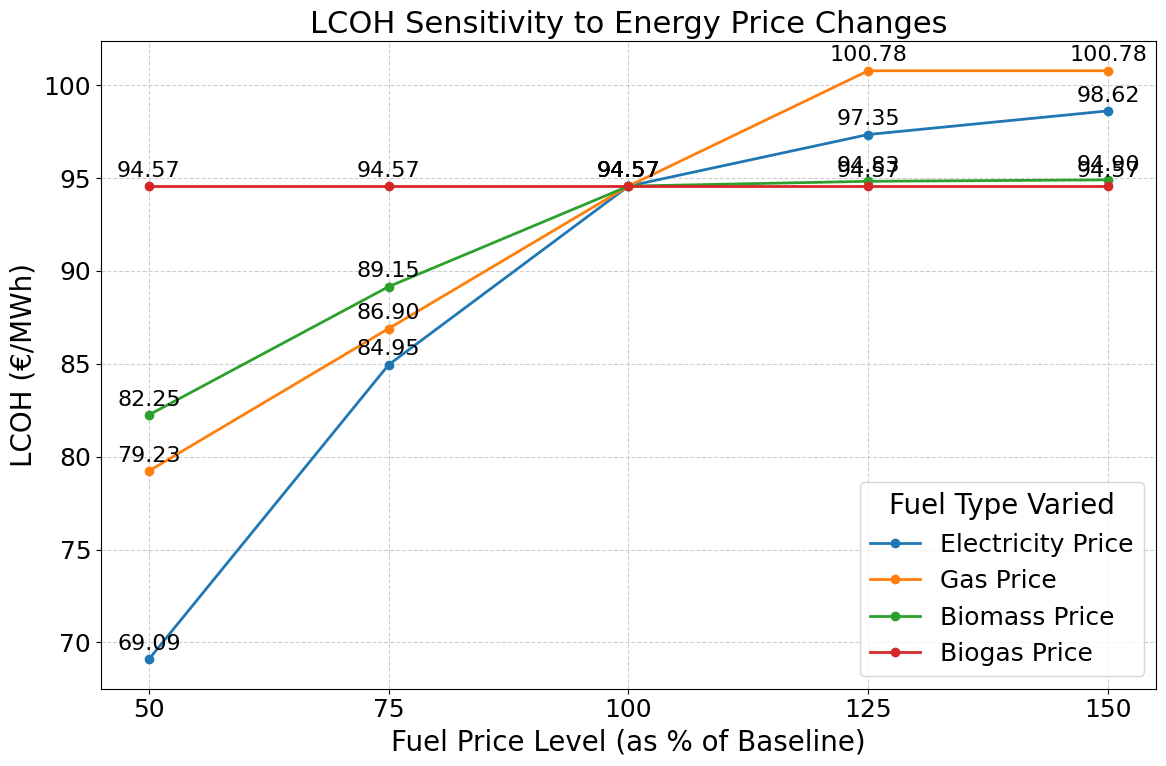

          LCOH  total_cost  share_2025  share_2040  share_2050   model  \
0    69.088494   12.290746         0.5        0.75         1.0  [None]   
1    84.949606   15.112415         0.5        0.75         1.0  [None]   
2    94.565881   16.823137         0.5        0.75         1.0  [None]   
3    97.345699   17.317662         0.5        0.75         1.0  [None]   
4    98.617813   17.543970         0.5        0.75         1.0  [None]   
5    79.229305   14.094782         0.5        0.75         1.0  [None]   
6    86.897593   15.458959         0.5        0.75         1.0  [None]   
7    94.565881   16.823137         0.5        0.75         1.0  [None]   
8   100.778608   17.928372         0.5        0.75         1.0  [None]   
9   100.778608   17.928372         0.5        0.75         1.0  [None]   
10   82.246621   14.631558         0.5        0.75         1.0  [None]   
11   89.154462   15.860453         0.5        0.75         1.0  [None]   
12   94.565881   16.823137         0.5

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 18,           # Base font size for consistency
    "axes.titlesize": 22,      # Title font
    "axes.labelsize": 20,      # X and Y axis labels
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "legend.title_fontsize": 20,
})

plt.figure(figsize=(12, 8))  # Bigger figure for clarity

colors = {
    "Electricity Price": "tab:blue",
    "Gas Price": "tab:orange",
    "Biomass Price": "tab:green",
    "Biogas Price": "tab:red"
}

for param in df_energy_sens["Varied Parameter"].unique():
    subset = df_energy_sens[df_energy_sens["Varied Parameter"] == param]
    x = subset["Level (%)"]
    y = subset["LCOH"]

    plt.plot(x, y, marker='o', label=param, color=colors[param], linewidth=2)

    # Add text labels
    for i in range(len(x)):
        plt.text(x.iloc[i], y.iloc[i] + 0.5, f"{y.iloc[i]:.2f}",
                 ha='center', fontsize=16)

plt.xlabel("Fuel Price Level (as % of Baseline)")
plt.ylabel("LCOH (€/MWh)")
plt.title("LCOH Sensitivity to Energy Price Changes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([50, 75, 100, 125, 150])
plt.legend(title="Fuel Type Varied")
plt.tight_layout()
plt.show()

print(df_energy_sens)


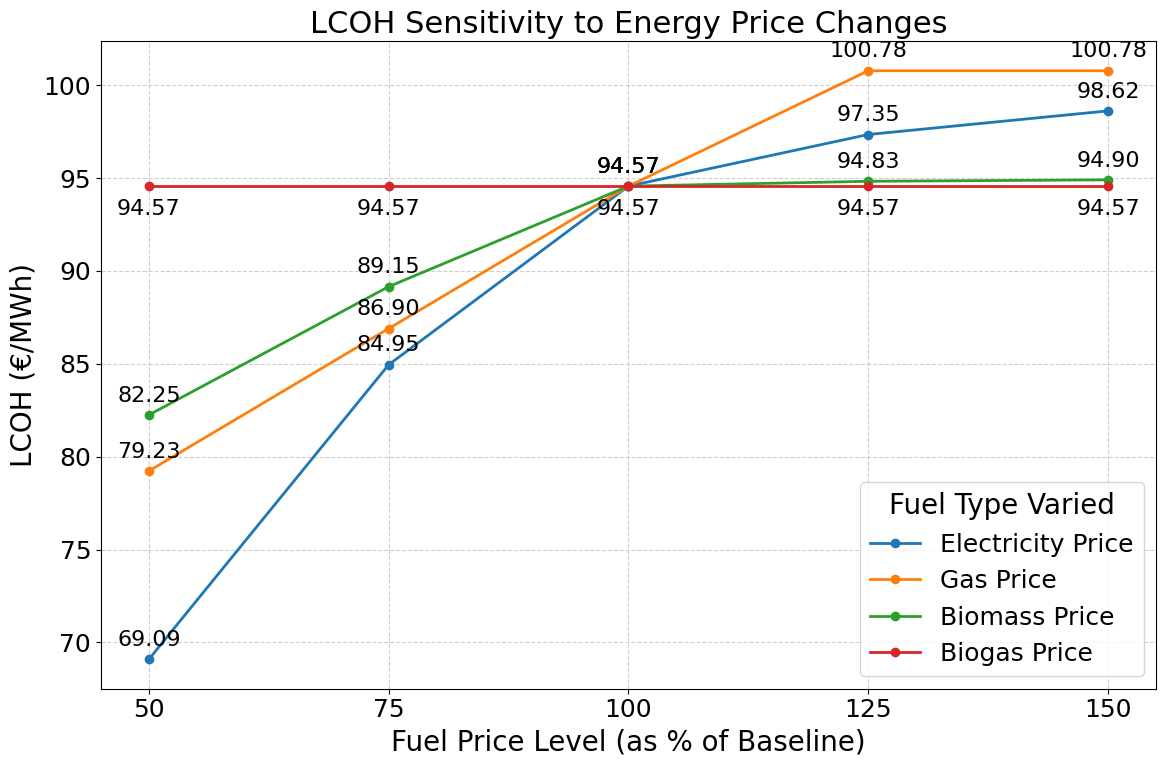

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "legend.title_fontsize": 20,
})

plt.figure(figsize=(12, 8))

colors = {
    "Electricity Price": "tab:blue",
    "Gas Price": "tab:orange",
    "Biomass Price": "tab:green",
    "Biogas Price": "tab:red"
}

for param in df_energy_sens["Varied Parameter"].unique():
    subset = df_energy_sens[df_energy_sens["Varied Parameter"] == param]
    x = subset["Level (%)"]
    y = subset["LCOH"]

    plt.plot(x, y, marker='o', label=param, color=colors[param], linewidth=2)

    # Add text labels
    for i in range(len(x)):
        offset = -0.7 if param == "Biogas Price" else 0.5
        va = 'top' if param == "Biogas Price" else 'bottom'
        plt.text(x.iloc[i], y.iloc[i] + offset, f"{y.iloc[i]:.2f}",
                 ha='center', va=va, fontsize=16)

plt.xlabel("Fuel Price Level (as % of Baseline)")
plt.ylabel("LCOH (€/MWh)")
plt.title("LCOH Sensitivity to Energy Price Changes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([50, 75, 100, 125, 150])
plt.legend(title="Fuel Type Varied")
plt.tight_layout()
plt.show()


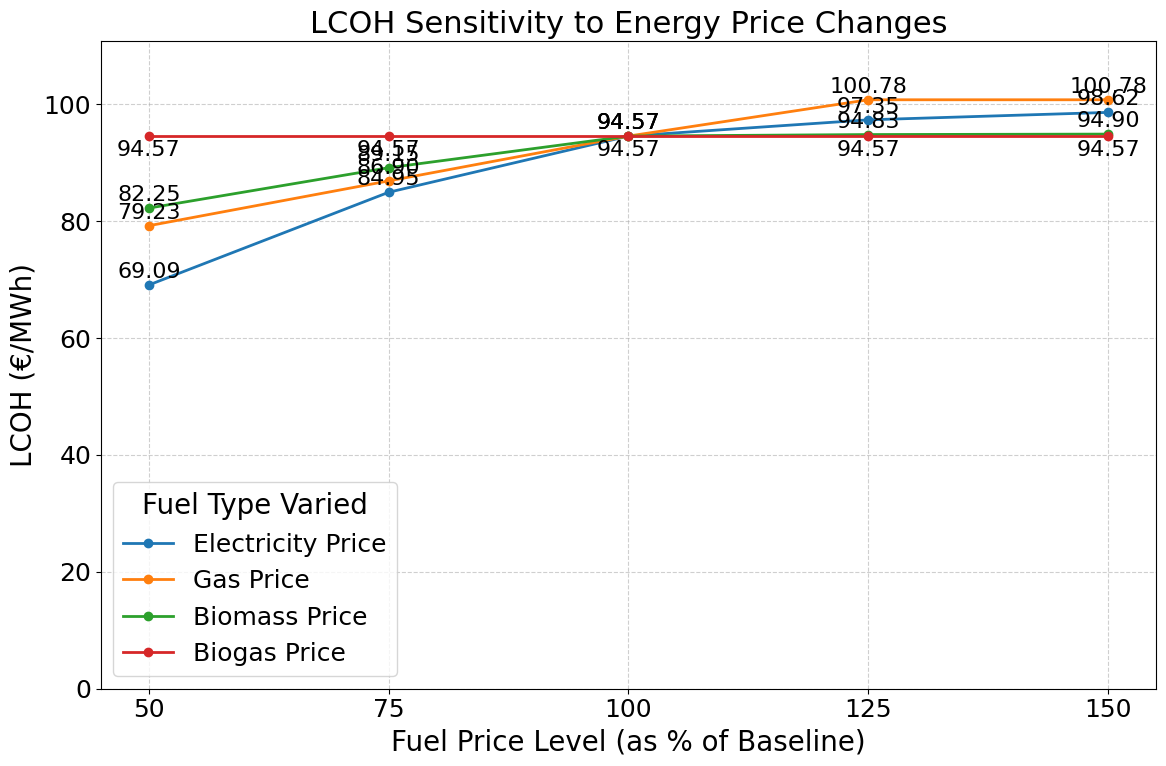

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "legend.title_fontsize": 20,
})

plt.figure(figsize=(12, 8))

colors = {
    "Electricity Price": "tab:blue",
    "Gas Price": "tab:orange",
    "Biomass Price": "tab:green",
    "Biogas Price": "tab:red"
}

for param in df_energy_sens["Varied Parameter"].unique():
    subset = df_energy_sens[df_energy_sens["Varied Parameter"] == param]
    x = subset["Level (%)"]
    y = subset["LCOH"]

    plt.plot(x, y, marker='o', label=param, color=colors[param], linewidth=2)

    for i in range(len(x)):
        offset = -0.7 if param == "Biogas Price" else 0.5
        va = 'top' if param == "Biogas Price" else 'bottom'
        plt.text(x.iloc[i], y.iloc[i] + offset, f"{y.iloc[i]:.2f}",
                 ha='center', va=va, fontsize=16)

plt.xlabel("Fuel Price Level (as % of Baseline)")
plt.ylabel("LCOH (€/MWh)")
plt.title("LCOH Sensitivity to Energy Price Changes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([50, 75, 100, 125, 150])
plt.ylim(0, df_energy_sens["LCOH"].max() + 10)  # <-- y-axis starts at 0
plt.legend(title="Fuel Type Varied")
plt.tight_layout()
plt.show()


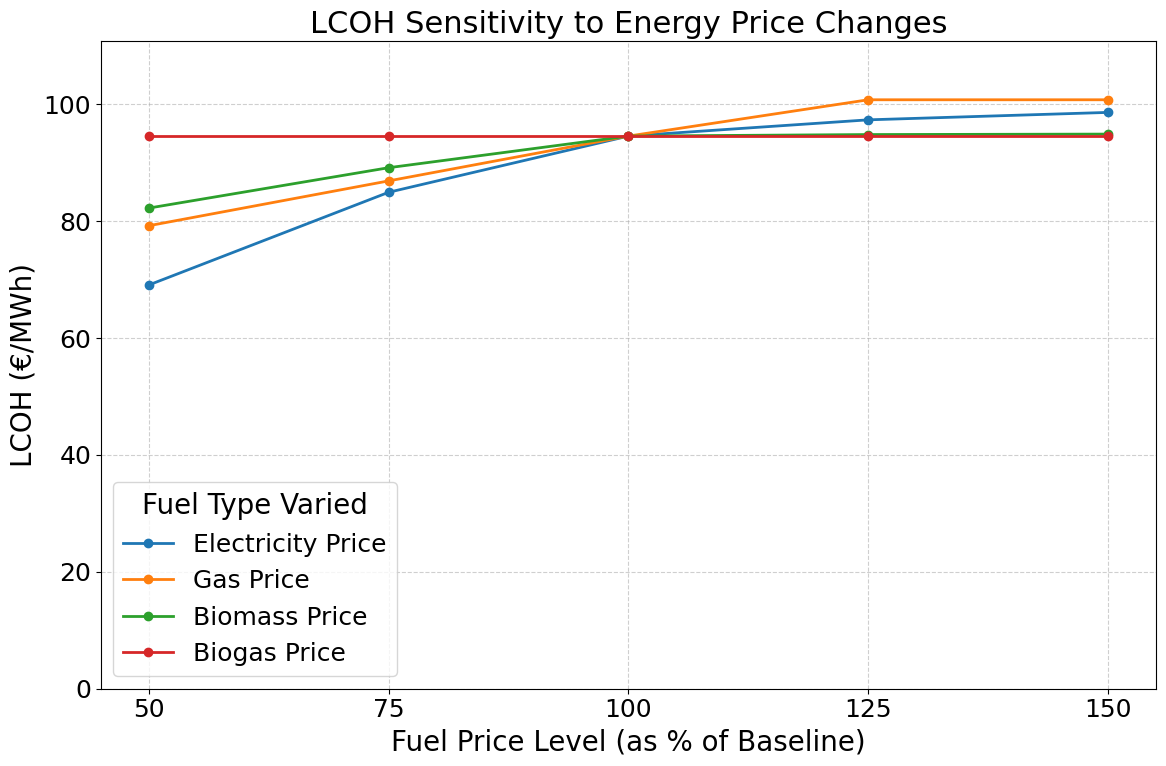

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "legend.title_fontsize": 20,
})

plt.figure(figsize=(12, 8))

colors = {
    "Electricity Price": "tab:blue",
    "Gas Price": "tab:orange",
    "Biomass Price": "tab:green",
    "Biogas Price": "tab:red"
}

for param in df_energy_sens["Varied Parameter"].unique():
    subset = df_energy_sens[df_energy_sens["Varied Parameter"] == param]
    x = subset["Level (%)"]
    y = subset["LCOH"]

    plt.plot(x, y, marker='o', label=param, color=colors[param], linewidth=2)

plt.xlabel("Fuel Price Level (as % of Baseline)")
plt.ylabel("LCOH (€/MWh)")
plt.title("LCOH Sensitivity to Energy Price Changes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([50, 75, 100, 125, 150])
plt.ylim(0, df_energy_sens["LCOH"].max() + 10)
plt.legend(title="Fuel Type Varied")
plt.tight_layout()
plt.show()


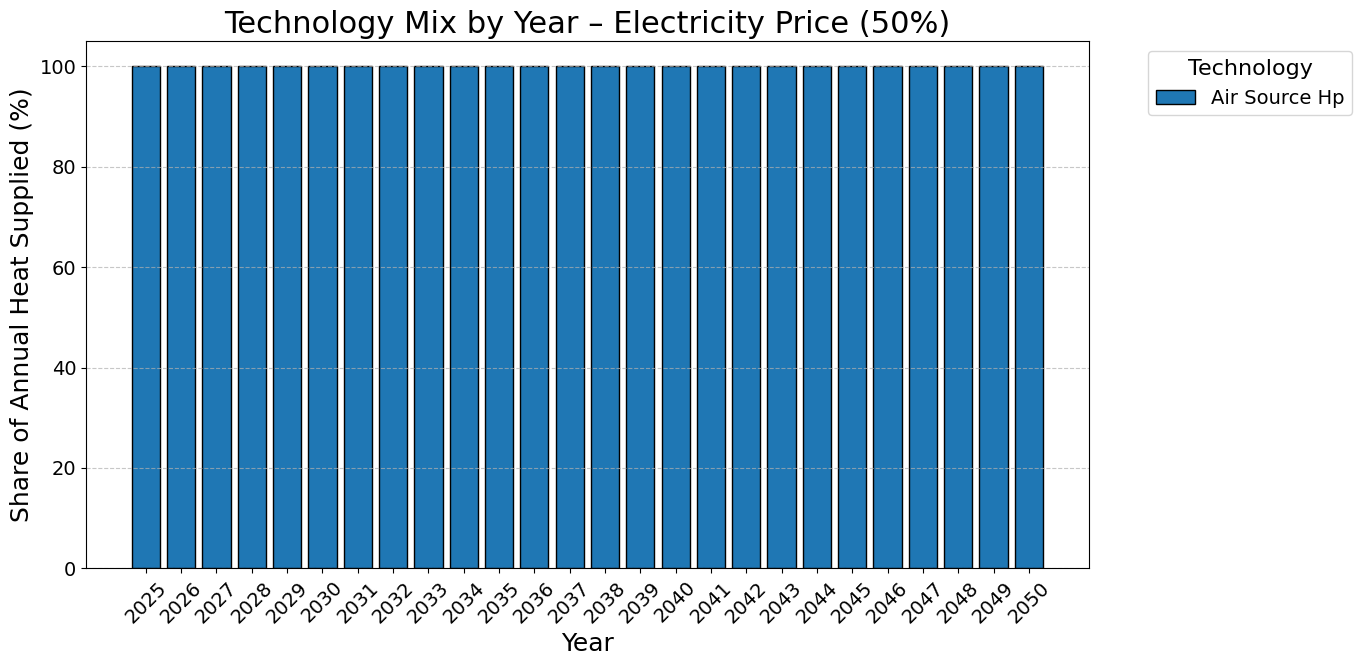

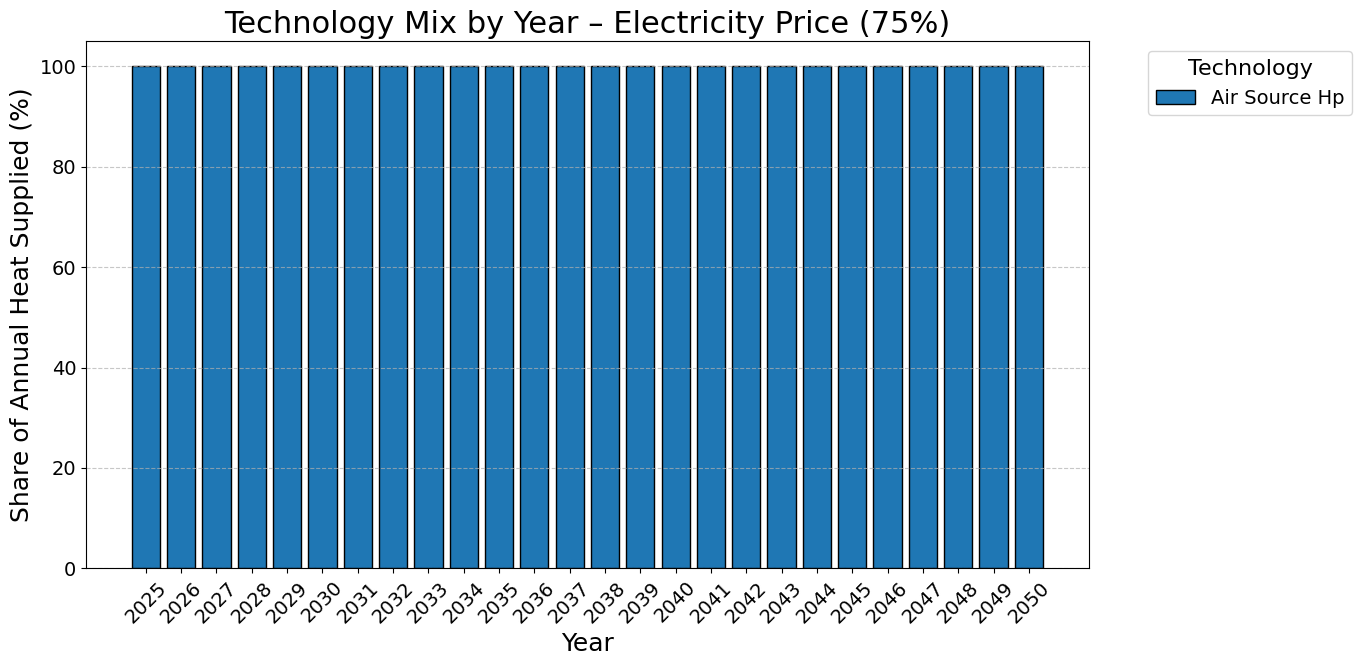

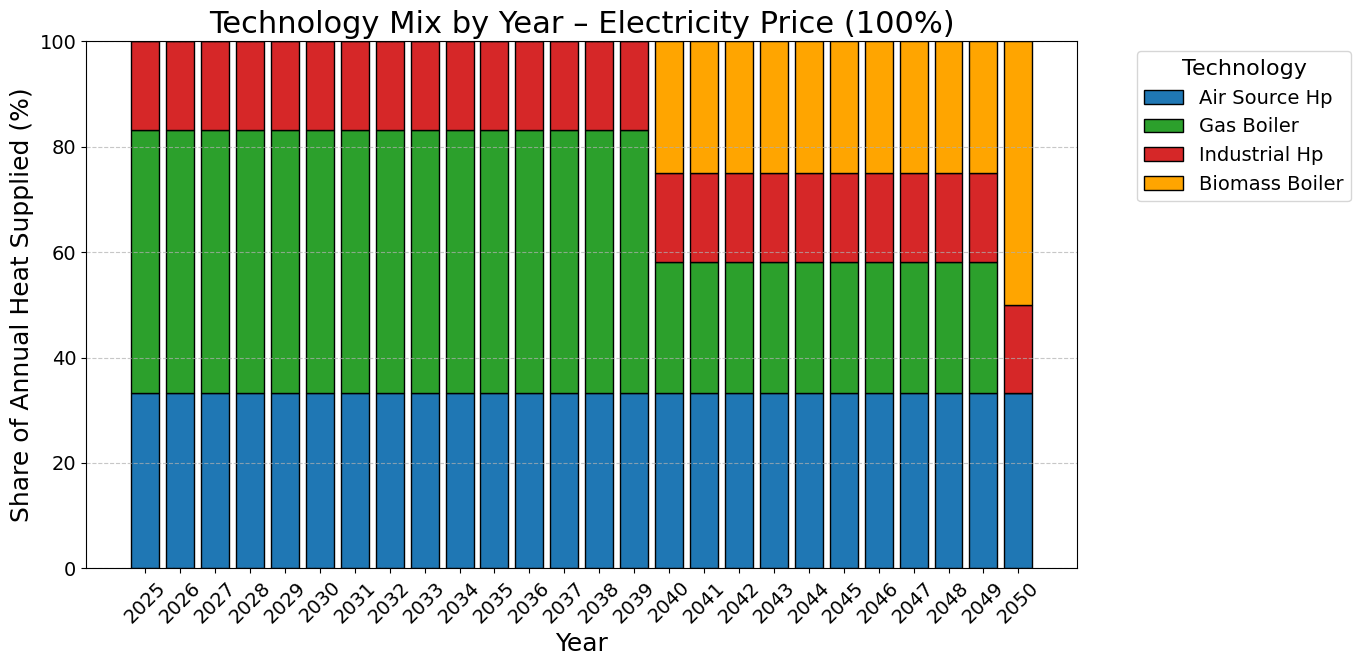

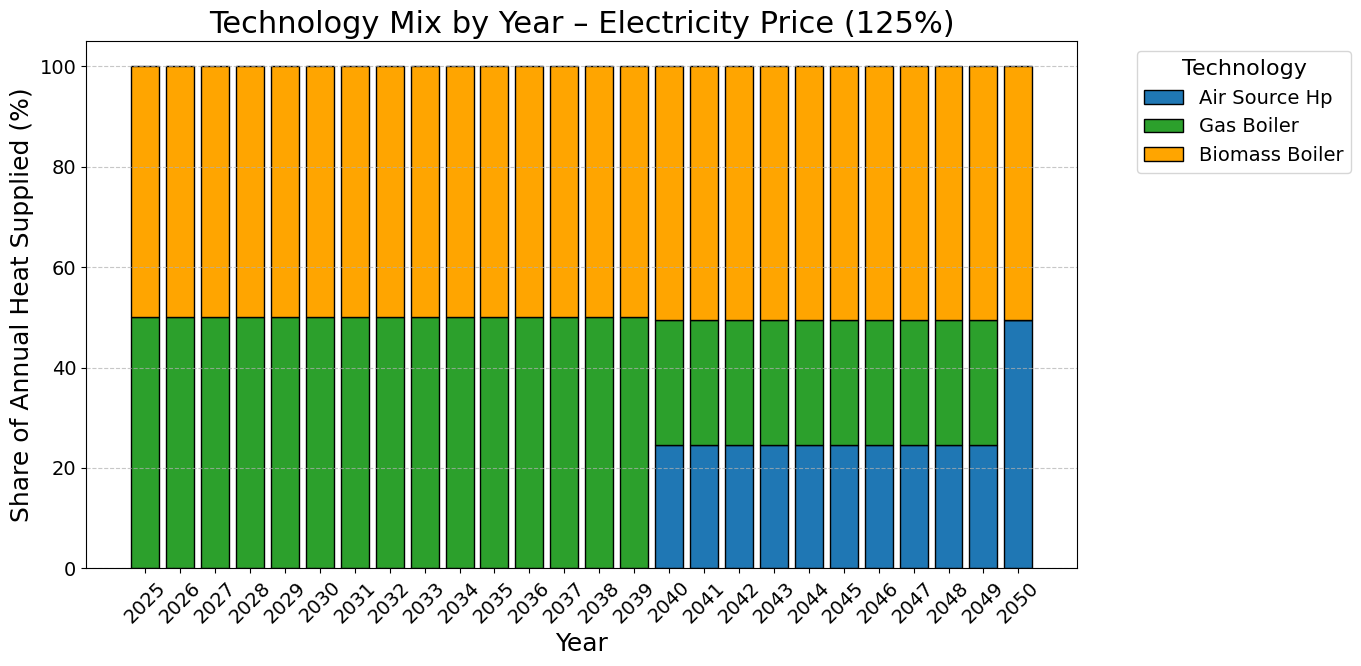

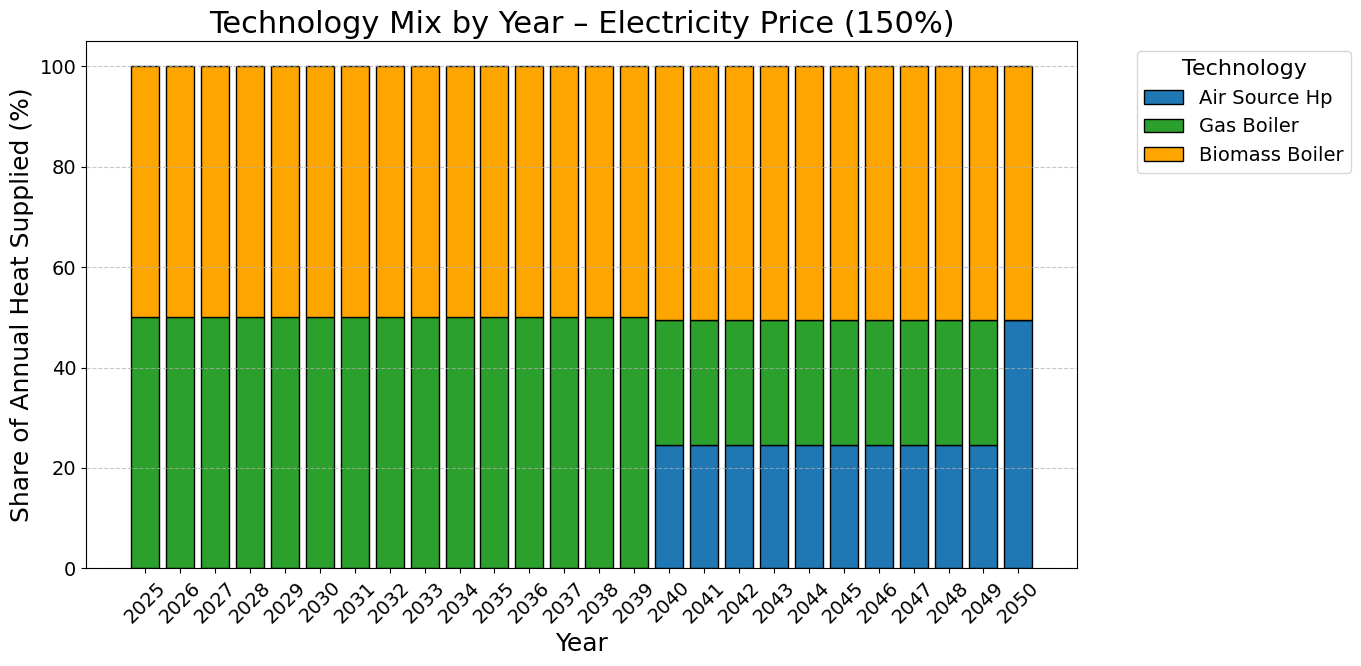

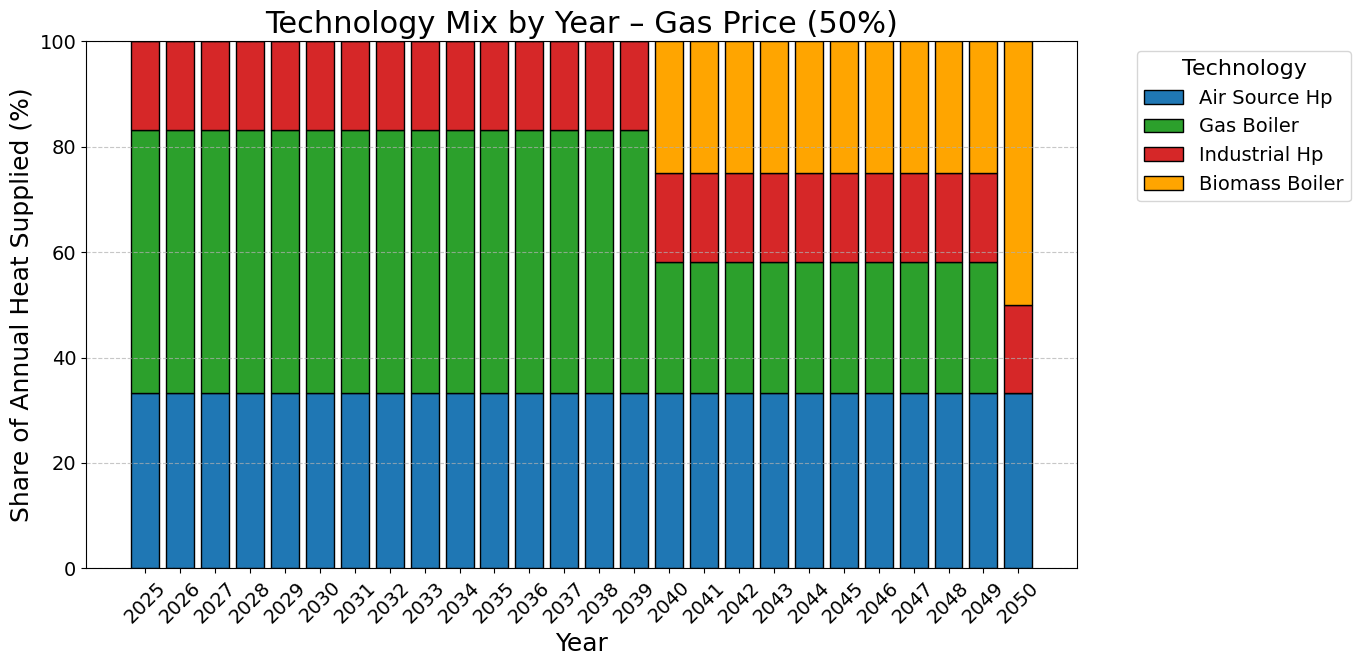

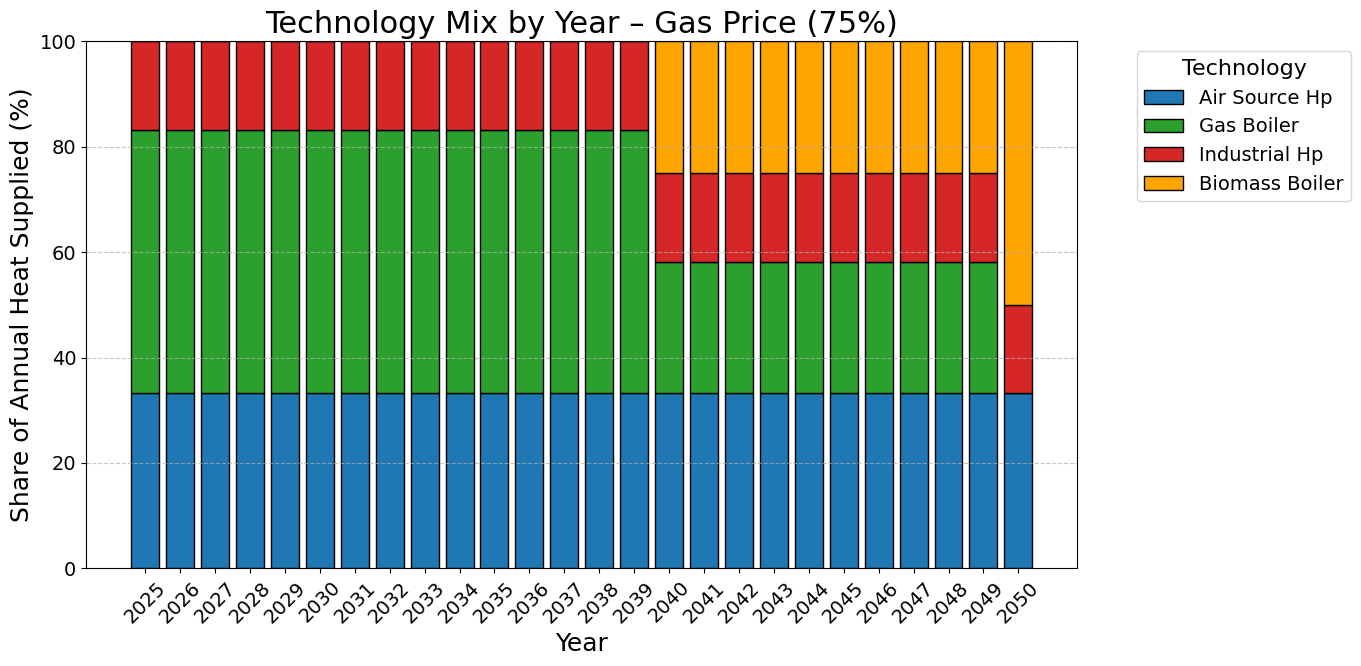

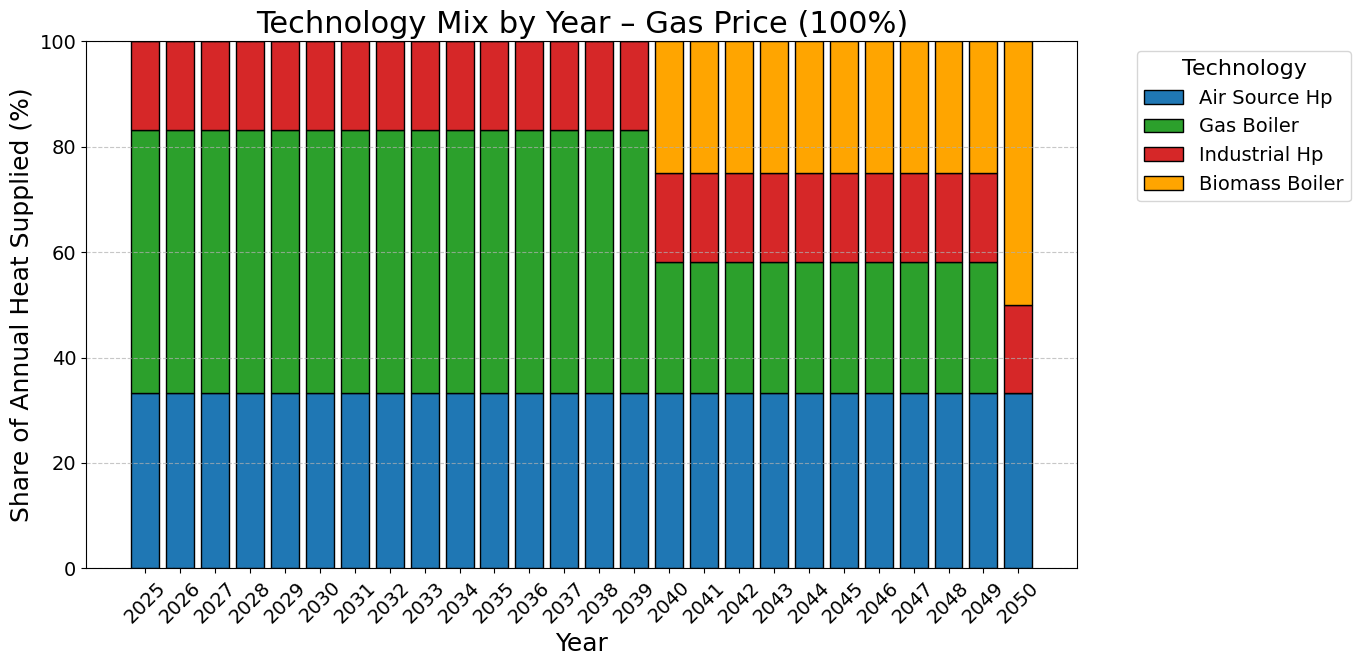

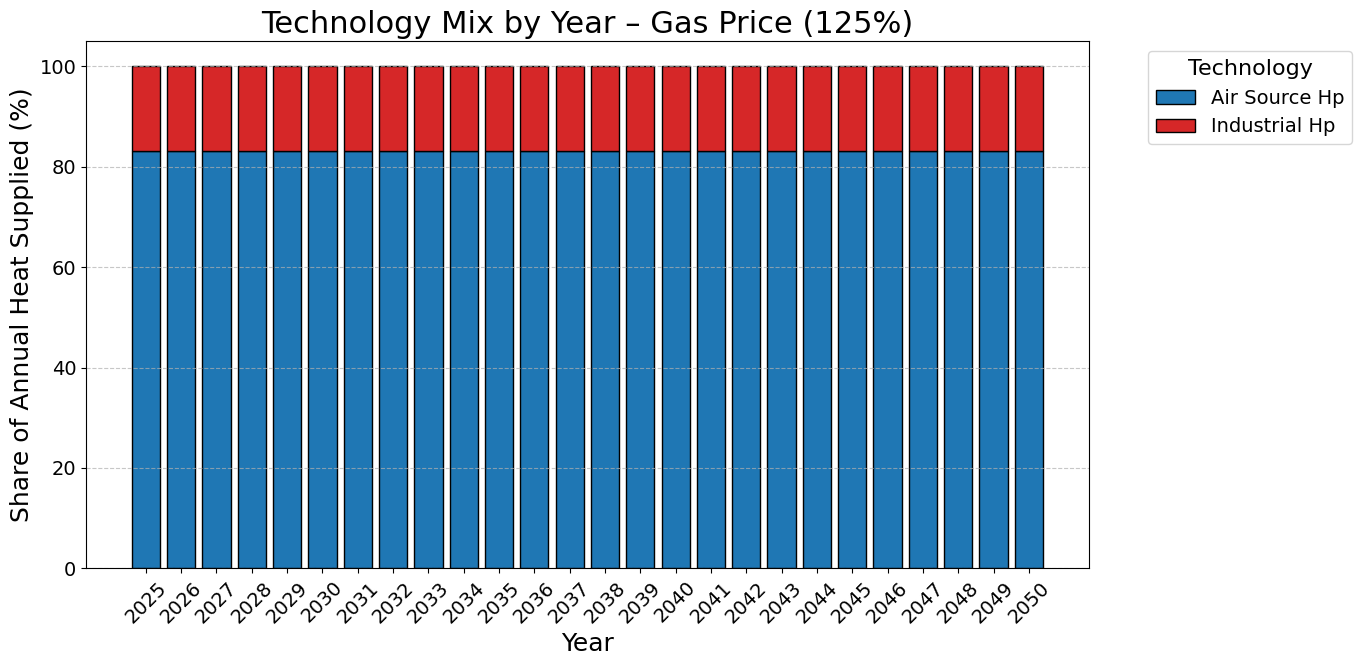

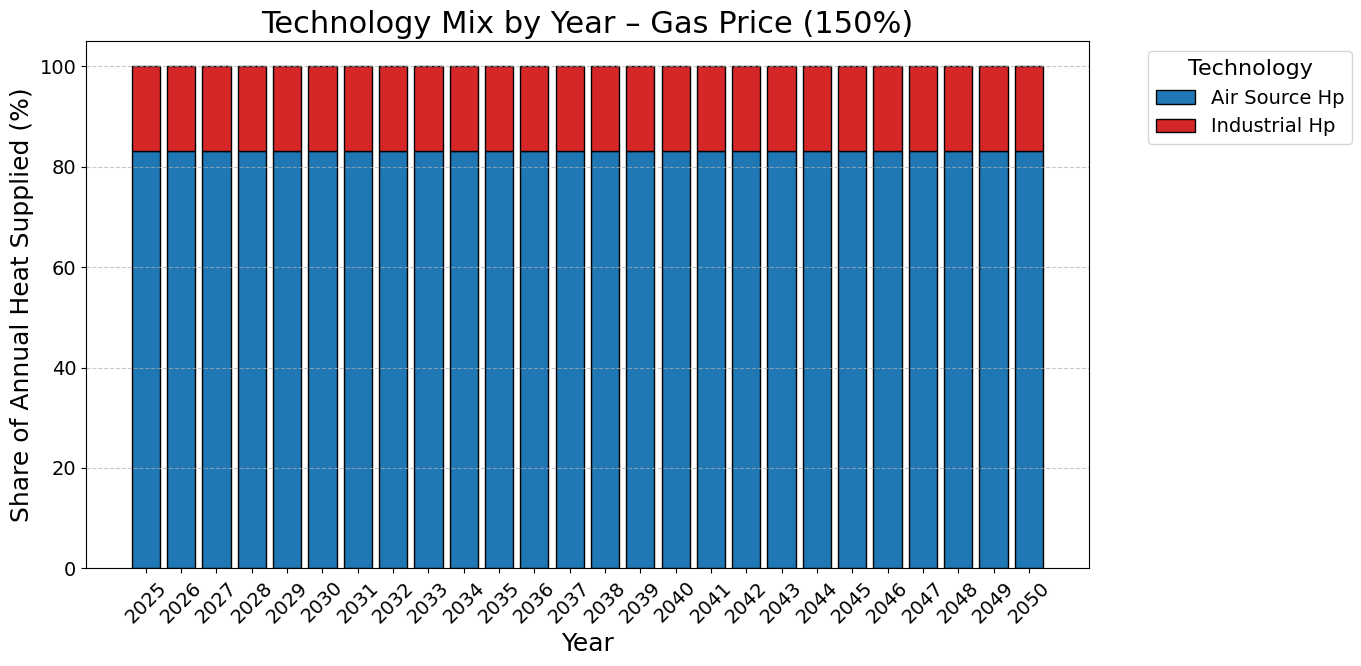

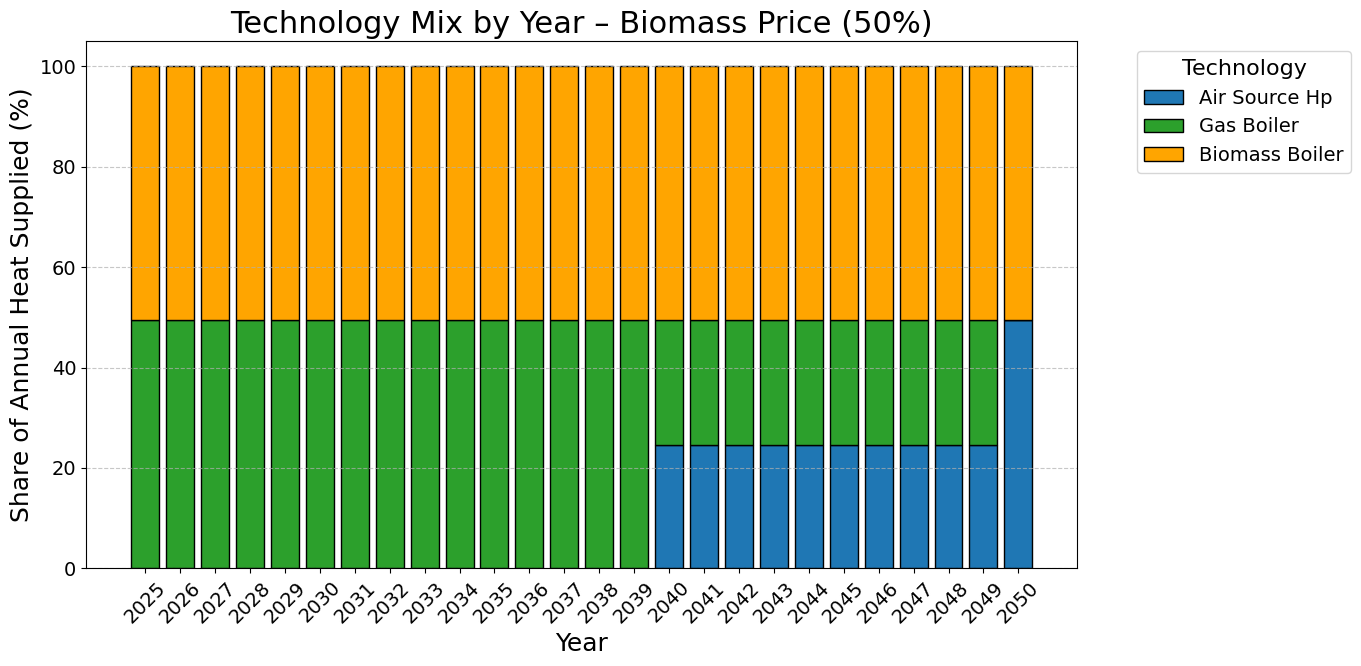

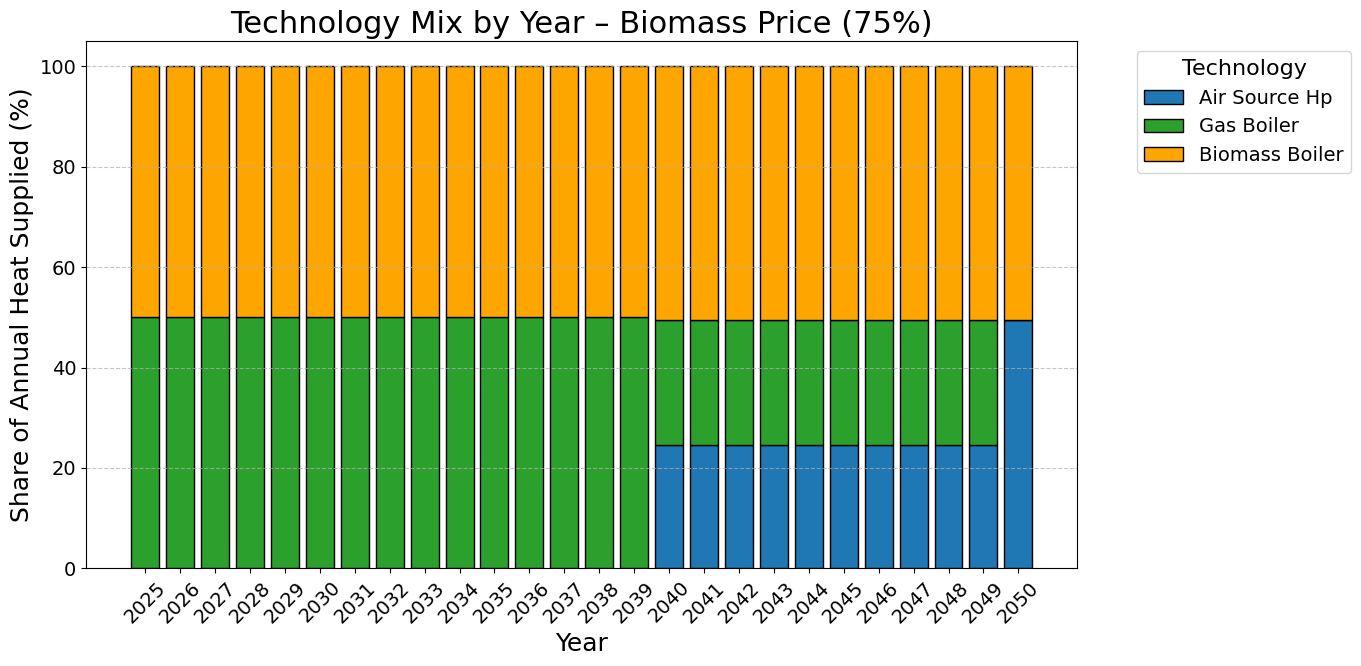

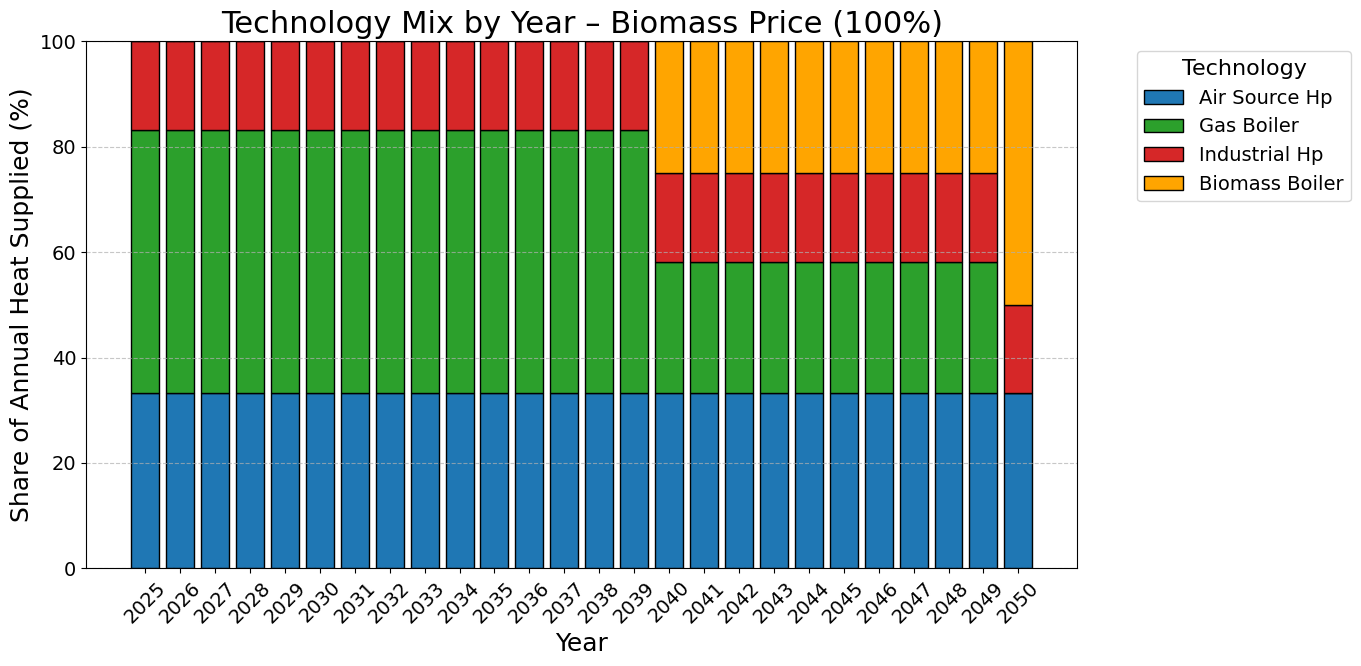

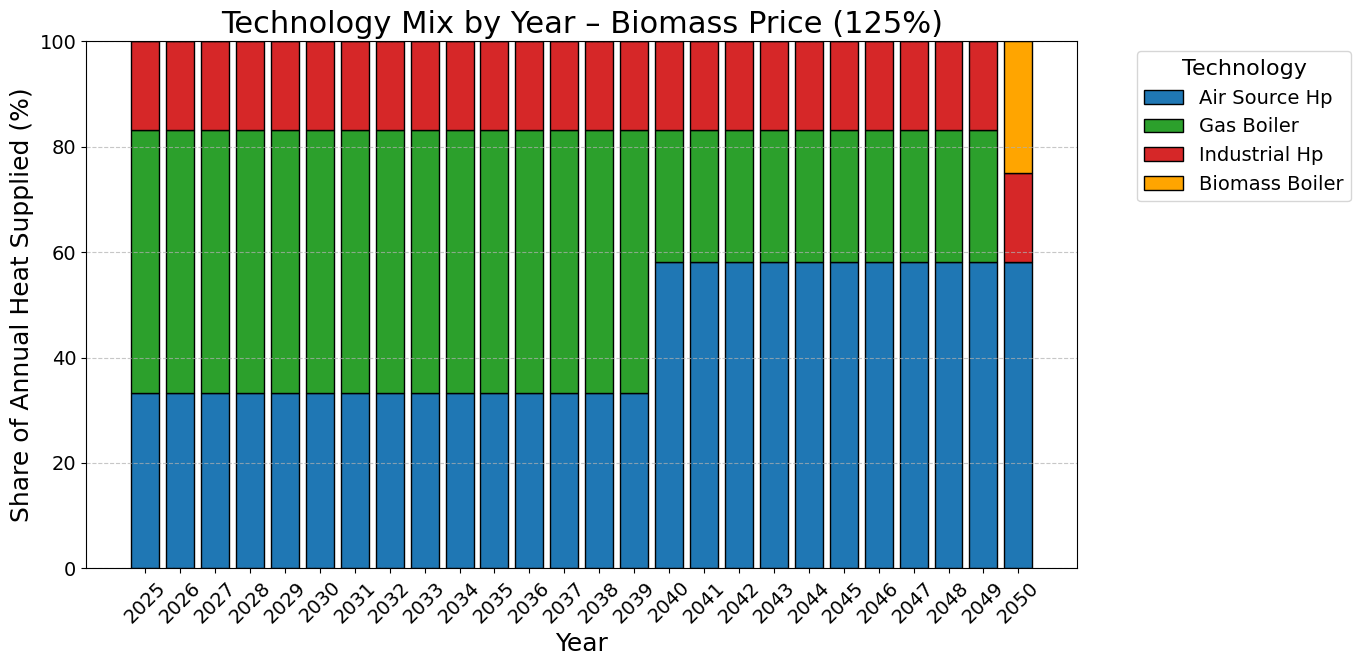

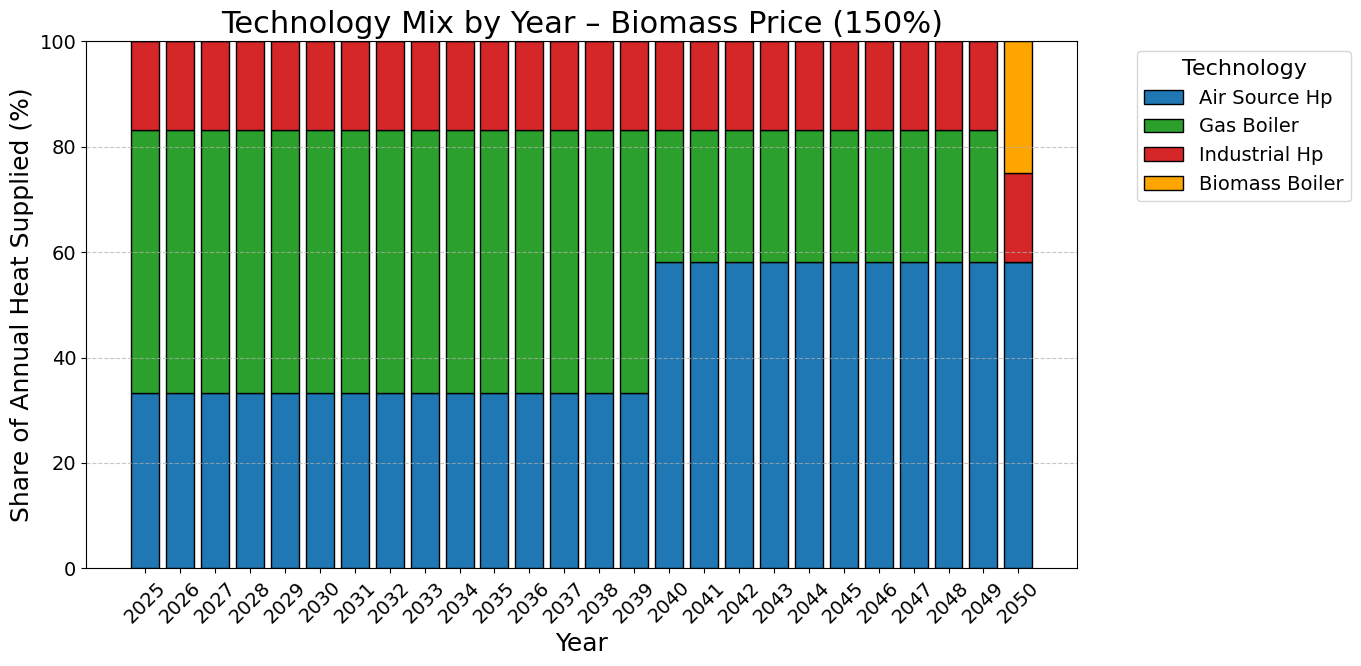

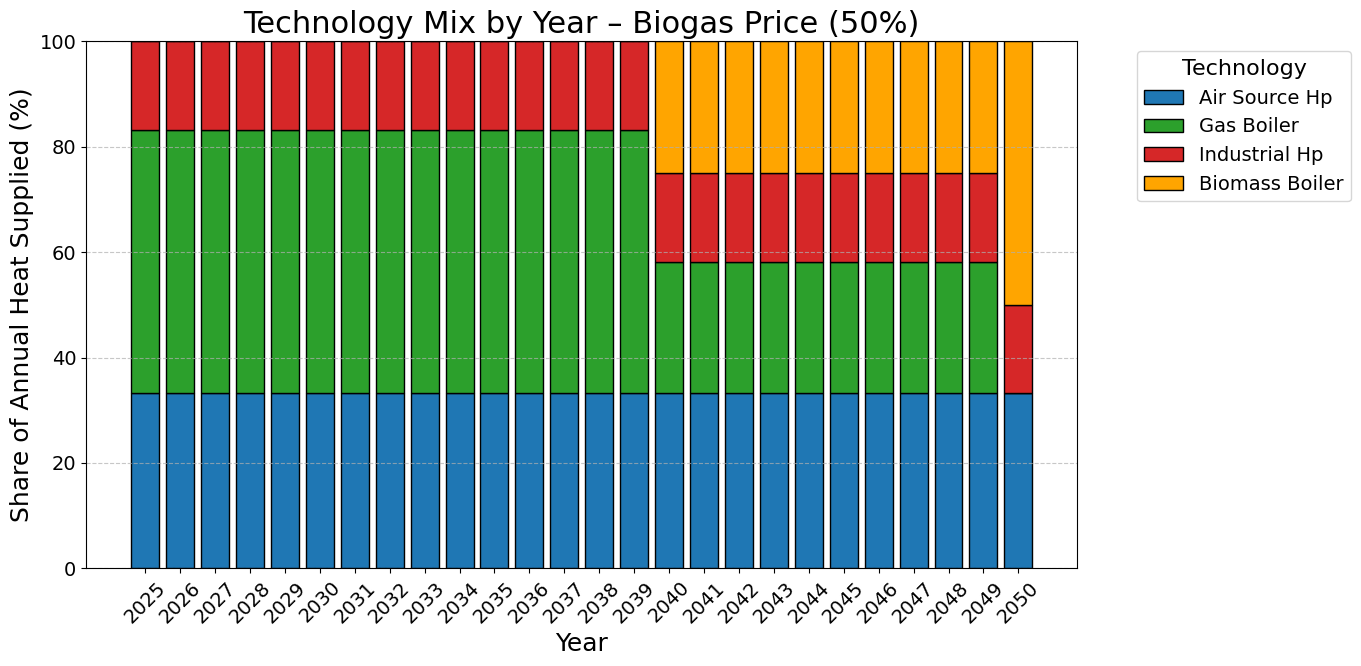

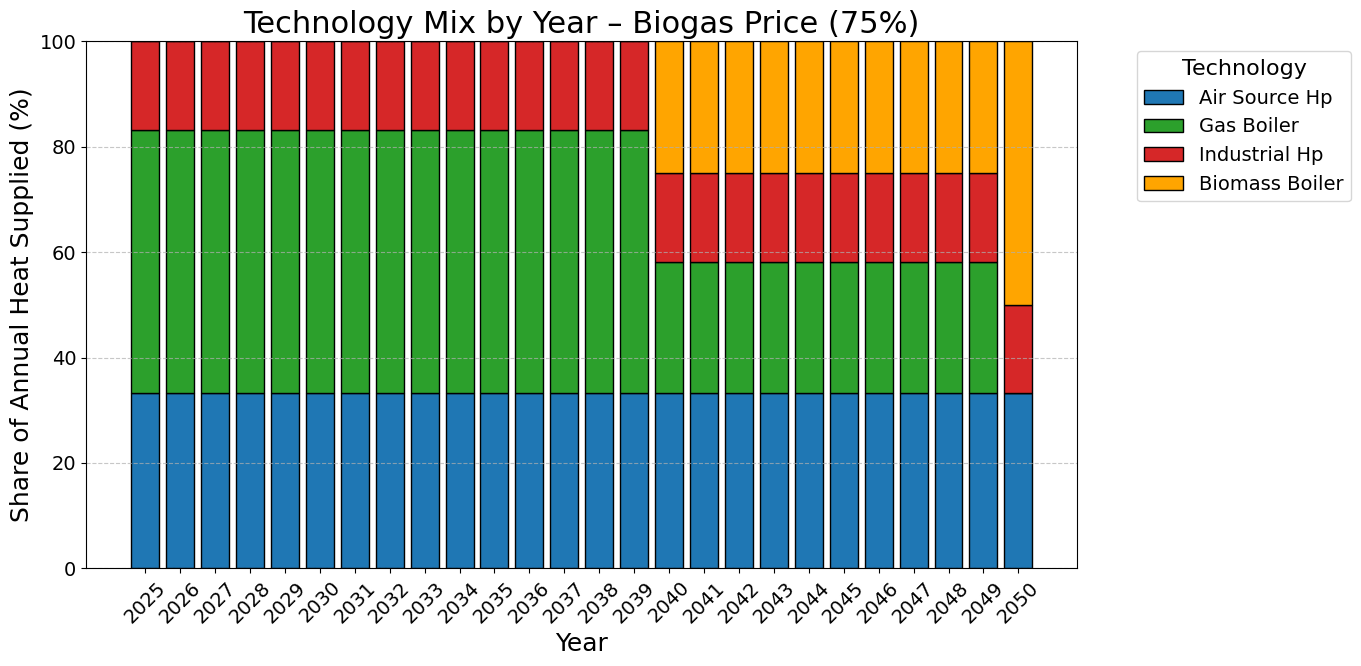

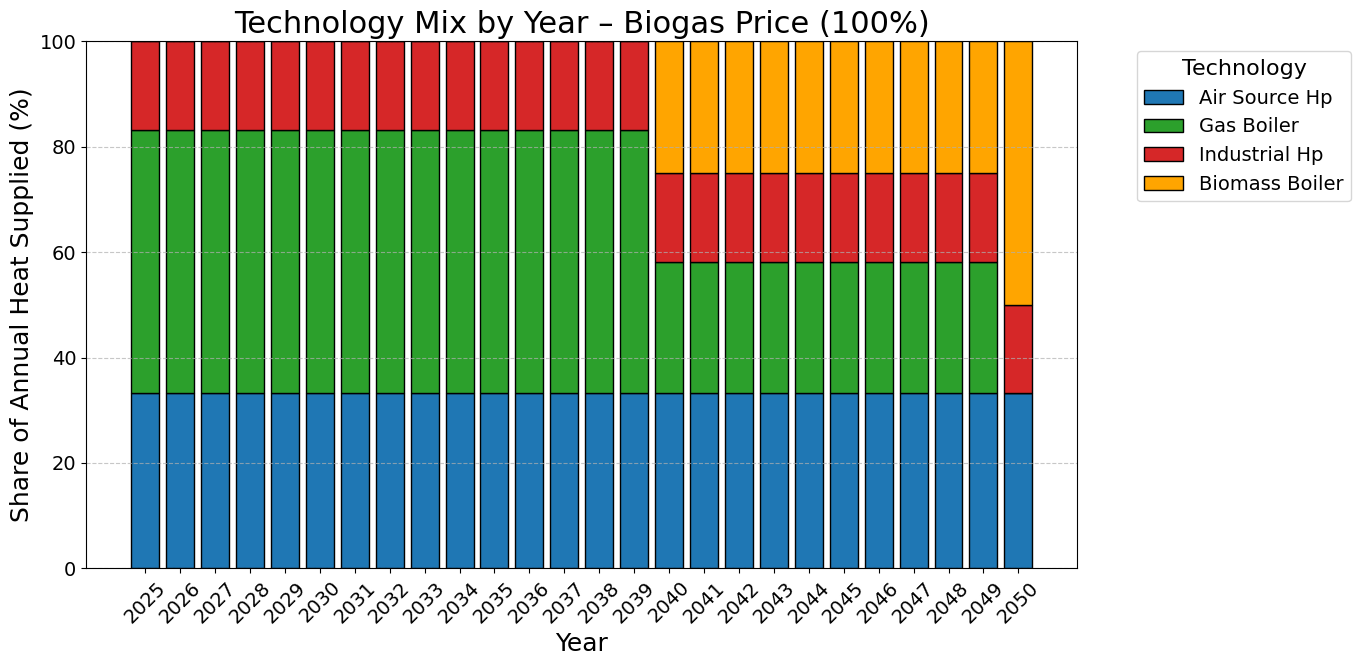

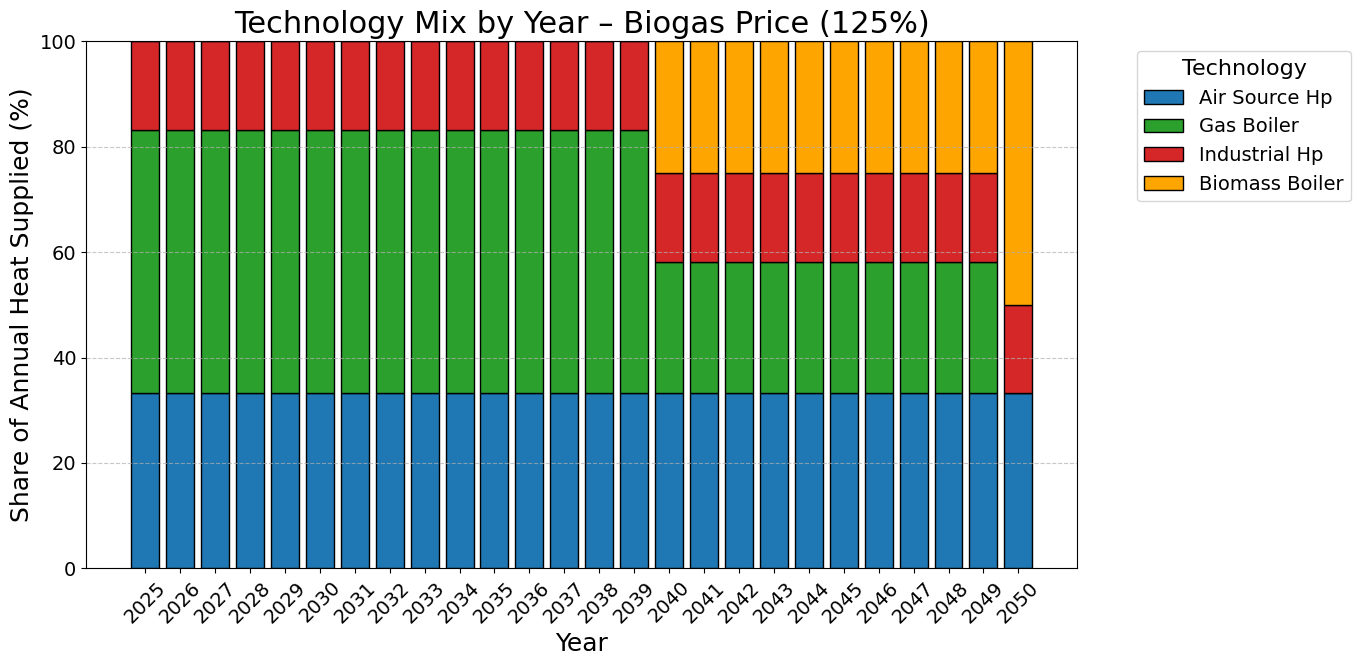

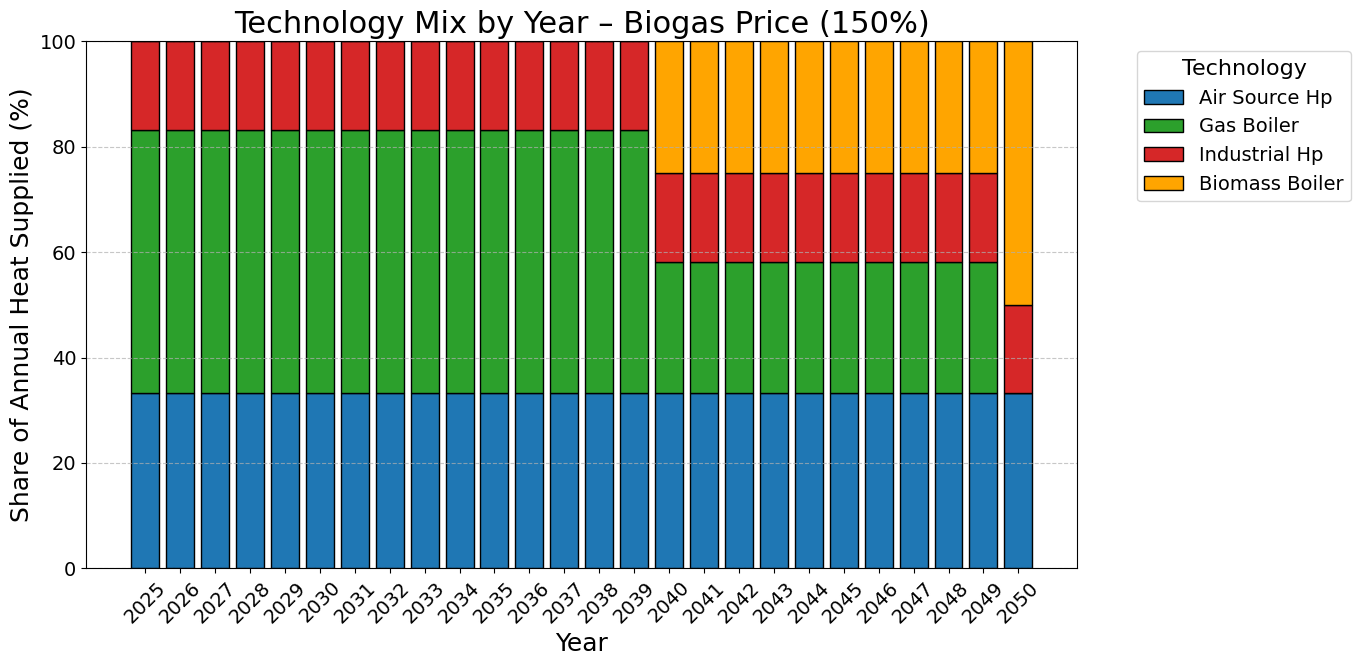


--- Scenario: Electricity Price (50%) ---
2025: air_source_hp → 5.95 MW
2026: air_source_hp → 5.95 MW
2027: air_source_hp → 5.95 MW
2028: air_source_hp → 5.95 MW
2029: air_source_hp → 5.95 MW
2030: air_source_hp → 5.95 MW
2031: air_source_hp → 5.95 MW
2032: air_source_hp → 5.95 MW
2033: air_source_hp → 5.95 MW
2034: air_source_hp → 5.95 MW
2035: air_source_hp → 5.95 MW
2036: air_source_hp → 5.95 MW
2037: air_source_hp → 5.95 MW
2038: air_source_hp → 5.95 MW
2039: air_source_hp → 5.95 MW
2040: air_source_hp → 5.95 MW
2041: air_source_hp → 5.95 MW
2042: air_source_hp → 5.95 MW
2043: air_source_hp → 5.95 MW
2044: air_source_hp → 5.95 MW
2045: air_source_hp → 5.95 MW
2046: air_source_hp → 5.95 MW
2047: air_source_hp → 5.95 MW
2048: air_source_hp → 5.95 MW
2049: air_source_hp → 5.95 MW
2050: air_source_hp → 5.95 MW

--- Scenario: Electricity Price (75%) ---
2025: air_source_hp → 5.95 MW
2026: air_source_hp → 5.95 MW
2027: air_source_hp → 5.95 MW
2028: air_source_hp → 5.95 MW
2029: air_sour

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Constants
EFLH = 1800
years = range(2025, 2051)
techs = ['air_source_hp', 'gas_boiler', 'industrial_hp', 'biomass_boiler', 'sofc', 'geothermal_hp', 'electric_boiler']

# Custom tech colors
tech_colors = {
    'air_source_hp': 'tab:blue',
    'gas_boiler': 'tab:green',
    'industrial_hp': 'tab:red',
    'biomass_boiler': 'orange',
    'sofc': 'tab:purple',
    'geothermal_hp': 'tab:gray',
    'electric_boiler': 'tab:brown'
}

# Create readable scenario labels
labels = [f"{row['Varied Parameter']} ({row['Level (%)']}%)" for _, row in df_energy_sens.iterrows()]

# Loop through scenarios
for i, row in df_energy_sens.iterrows():
    model = row["model"]
    label = labels[i]

    # Collect heat output
    data = {
        "Year": [],
        "Technology": [],
        "Heat_MWh": []
    }

    for year in years:
        for tech in techs:
            heat = pyo.value(model.xy[tech, year]) * EFLH
            data["Year"].append(year)
            data["Technology"].append(tech)
            data["Heat_MWh"].append(heat)

    df = pd.DataFrame(data)

    # Pivot to years × techs
    df_pivot = df.pivot(index="Year", columns="Technology", values="Heat_MWh")
    df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

    # Identify used techs
    used_techs = [tech for tech in techs if tech in df_percent.columns and (df_percent[tech] != 0).any()]

    # Plot
    plt.figure(figsize=(14, 7))
    bottom = np.zeros(len(df_percent))

    for tech in used_techs:
        plt.bar(df_percent.index, df_percent[tech], bottom=bottom,
                label=tech.replace("_", " ").title(),
                color=tech_colors[tech],
                edgecolor='black')
        bottom += df_percent[tech].fillna(0)

    plt.title(f"Technology Mix by Year – {label}", fontsize=22)
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("Share of Annual Heat Supplied (%)", fontsize=18)
    plt.xticks(df_percent.index, rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
for i, row in df_energy_sens.iterrows():
    model = row["model"]
    scenario_label = f"{row['Varied Parameter']} ({row['Level (%)']}%)"
    print(f"\n--- Scenario: {scenario_label} ---")
    for tech in techs:
        for year in years:
            cap = pyo.value(model.x[tech, year])
            if cap > 0:
                print(f"{year}: {tech} → {cap:.2f} MW")


In [ ]:
# Print deployment years only for each technology under each scenario
for i, row in df_energy_sens.iterrows():
    model = row["model"]
    scenario_label = f"{row['Varied Parameter']} ({row['Level (%)']}%)"
    print(f"\n--- Scenario: {scenario_label} ---")

    for tech in techs:
        deployed_years = []
        for year in years:
            cap = pyo.value(model.x[tech, year])
            if cap > 0:
                deployed_years.append(year)

        if deployed_years:
            year_str = ", ".join(str(y) for y in deployed_years)
            print(f"{tech}: {year_str}")



--- Scenario: Electricity Price (50%) ---
air_source_hp: 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050

--- Scenario: Electricity Price (75%) ---
air_source_hp: 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050

--- Scenario: Electricity Price (100%) ---
air_source_hp: 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050
gas_boiler: 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050
industrial_hp: 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050
biomass_boiler: 2040, 2